# Intro<br>
This file is to apply Isolation Forest and PCA (unsupervised machine learning) to Hailong data that has been clustered based on <b>account pairings (interaction + account id)</b> found in the journal documents. Interaction is either Debit (Dr) or Credit (Cr). <br>It is later saved in Account_pairing_cluster.xlsx <br><br>
For more cluster information, refer to please [clustering.ipynb](clustering.ipynb)
<br><br>
<b><u>Sections:</b></u>
<ul>
    <li><b>Import data and libraries</b></li>
    <li><b>Clustering:</b> create a dataframe which assigns each journal entry line to a cluster</li>
    <li><b>Feature functions:</b> Feature functions applied to data in line entry format, new columns created </li>
    <li><b>Make JE raw dataframe:</b><br> Make a dataframe where data + new feature columns are grouped in journal document format (JE_Doc_ID). <br>Journal documents where <u>all</u> its line entries are crediting/debiting 0 are removed.<br>Input dataframe (features_df) created</li>
    <li><b>Isolation Forest:</b> Run Isolation Forest algorithm on input dataframe</li>
    <li><b>PCA:</b> Run PCA (Principal Component Analysis) algorithm on input dataframe</li>
    <li><b>Comparing:</b> Compare PCA and Isolation Forest anomaly results to see if both algorithms found the same anomalies.<br>If journal document is found anomalous in both algorithms, ISF_PCA_anomalies column = 1</li>
    <li><b>Saving:</b> Results saved into <u>Acc_pairing_cluster.xlsx</u>.<br>Sheets are edited to highlight feature columns and hide unnecessary columns</li>   
    <li><b>Validate top 5 anomalies:</b> Create boxplot distributions of where top 5 anomalous journal documents are found in their respective clusters</li>
</ul>

<b>Key:</b><br>
{algo}<br>
ISF = Isolation Forest<br>
PCA = Principal Component Analysis<br>

{week} -> each specific week (Week1, Week2, Week3, Week4)
<br><br>
<b>Acc_pairing_cluster.xlsx sheets:</b>
<ol>
    <li><b>{algo}_result_je:</b> Algorithm's result saved in journal document format</li>
    <li><b>{algo}_result_raw:</b> Algorithm's result saved in journal entry line format</li>
    <li><b>{algo}_cluster_metrics:</b> Cluster metrics found in Algorithm's result (biggest cluster at the top)</li><br>
        <ul>
        <li>Cluster_Population: Number of journal documents in the cluster</li>
        <li>Cluster_Anomalies: Number of anomalies found in the cluster</li>
        <li>ISF_PCA_Anomalies Count: Number of anomalies found by both Isolation Forest and PCA in the cluster</li>
        <li>Cluster_Population (%): Percentage of journal documents out of the total population found in the cluster</li>
        <li>Cluster_Population (%) - Cummulative: Cluster Population percentage accumulated down the sheet</li>
        <li>Percentage of anomalies in Cluster: Percentage of cluster that are anomalies</li>
        <li>Percentage of total anomalies in Cluster: Percentage of total anomalies found in cluster</li>
        <li>Unique_accounts: List of Unique accounts found in cluster</li>
        <li>Num_unique_accs: Number of unique accounts found in cluster</li>
        </ul>    
    <li><b>Cluster_Week_freq:</b> Breakdown of each cluster's week frequency and it's details</li>
        <ul>
        <li>{week}_je_count: Number of journal documents found in that week</li>
        <li>{week}_avg_days_in_week: Average number of days in that week across the months</li>
        <li>{week}_je_frequency: Journal documents made per day in that week (je_count ÷ avg_days)</li>
        <li>{week}_je_%_frequency: Percentage of journal documents made in that week across all weeks (je_frequency ÷ sum of je_frequency across all weeks)</li>
        </ul>
    <li><b>Input_df:</b> input dataframe saved (features_df)</li>
</ol>

# Import data and libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from importlib import reload
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import ast
from datetime import datetime

import _00_util_sql
reload(_00_util_sql)
from _00_util_sql import Conn_ODBC
from collections import Counter

In [2]:
##### Import data 
sql_db=Conn_ODBC(database="JE_ML_2025")
conn=sql_db.odbc_conn_db_pyodbc()
sql_query=f"SELECT * FROM data_Hailong_staging_JE_updated_All"
h_data=sql_db.odbc_run_sql(conn, sql_query, return_result=True)
conn.close()

h_data.info()
# 10 sec

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51977 entries, 0 to 51976
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   CompanyName                             51977 non-null  object 
 1   ExcludeBalanceOnly                      51977 non-null  object 
 2   PrintReversedEntries                    51977 non-null  object 
 3   PageGroupNo                             51977 non-null  int64  
 4   PrintOnlyOnePerPage                     51977 non-null  object 
 5   PrintClosingEntries                     51977 non-null  object 
 6   PrintOnlyCorrections                    51977 non-null  object 
 7   EmptyString                             0 non-null      object 
 8   No_GLAcc                                51977 non-null  object 
 9   DetailTrialBalCaption                   51977 non-null  object 
 10  PageCaption                             51977 non-null  ob

# Clustering<br>
10010001 has 2 Name_GLAcc: Restricted Cash - Time Deposit(TWD), Restricted Cash - Time Deposit(NTD)<br>
60900200 has 2 Name_GLAcc: Cost Capatalization, Cost Capitalization

In [8]:
# Cleaning Account name

import re
# Step 1: Normalize descriptions
def normalize_name(name):
    """Normalize account names for comparison"""
    name = str(name).lower()
    name = re.sub(r'\s+', ' ', name).strip()
    name = name.replace('capatalization', 'capitalization')
    name = name.replace('(ntd)', '(twd)')
    return name


h_data['Normalized'] = h_data['Name_GLAcc'].apply(normalize_name)

# Step 2: Create distinct account labels
representative_labels = (
    h_data.groupby('No_GLAcc')['Normalized']
    .agg(lambda x: x.mode()[0])  # Choose most frequent normalized label
    .to_dict()
)

# Step 3: Merge clean labels back to dataset
h_data['Cleaned_NameGLAcc'] = h_data['No_GLAcc'].map(representative_labels)
h_data['Cleaned_NameGLAcc'].nunique()
# .to_excel(rf"d:\victoriaquek\JE ML 2025\Hailong\test.xlsx")

# Create distinct account labels (number + name)
h_data['Account_ID']=h_data['No_GLAcc'].astype(str)+' '+h_data['Cleaned_NameGLAcc'].str.lower()
# h_data['Account_ID'].value_counts().to_excel(rf"d:\victoriaquek\JE ML 2025\Hailong\test.xlsx")
h_data.drop(columns=['Normalized','Cleaned_NameGLAcc'], inplace=True)

# Count of number of distinct accounts
h_data['Account_ID'].nunique()

112

In [ ]:
# # Get the analytics of all the different cluster pairings in data
# def cluster_journal_entries_grouped_by_je(df):
#     """
#     Clusters journal entries into Dr/Cr/Zero groups by GL Account,
#     grouped by Journal Entry (CompanyName + DocumentNo_GLEntry),
#     and counts how many JE documents fall into each *unique combination* of clusters.

#     Parameters:
#         df (pd.DataFrame): Input data containing JE base info

#     Returns:
#         pd.DataFrame: Each unique combination of clusters with a count of JE documents
#     """

#     def get_cluster_type(row):
#         if row['DebitAmount_GLEntry'] != 0:
#             direction = 'Dr'
#         elif row['CreditAmount_GLEntry'] != 0:
#             direction = 'Cr'
#         else:
#             direction = 'Zero'

#         # Use normalized name in the cluster key
#         normalized_name = normalize_name(row['Name_GLAcc'])
#         return f"{direction} {row['No_GLAcc']} {normalized_name}"

#     df['Cluster'] = df.apply(get_cluster_type, axis=1)

#     df['JE_Doc_ID'] = df['CompanyName'].astype(str) + '|' + df['DocumentNo_GLEntry'].astype(str) + '|' + df['PostingDate_GLEntry'].astype(str)

#     # Convert cluster list to tuple so it's hashable
#     je_clusters = (
#         df[['JE_Doc_ID', 'Cluster']]
#         .drop_duplicates()
#         .groupby('JE_Doc_ID')['Cluster']
#         .apply(lambda x: tuple(sorted(x)))  # Ensure consistent ordering
#         .reset_index()
#     )

#     grouped_counts = (
#         je_clusters
#         .groupby('Cluster')
#         .size()
#         .reset_index(name='DocumentCount')
#         .sort_values(by='DocumentCount', ascending=False)
#     )

#     # Optional: convert Cluster back to list for readability
#     grouped_counts['Cluster'] = grouped_counts['Cluster'].apply(list)

#     # Assign a unique cluster ID
#     grouped_counts['Cluster_ID'] = [str(i) for i in range(1, len(grouped_counts) + 1)]

#     # Count number of accounts in each cluster
#     grouped_counts['AccountCount'] = grouped_counts['Cluster'].apply(len)

#     # Change back to tuple
#     grouped_counts['Cluster'] = grouped_counts['Cluster'].apply(tuple)

#     # Move Cluster_ID to the leftmost position
#     grouped_counts = grouped_counts[['Cluster_ID', 'Cluster', 'AccountCount', 'DocumentCount']]

#     return grouped_counts, len(grouped_counts)
 
# # Example usage
# result, cluster_count = cluster_journal_entries_grouped_by_je(h_data)
# result.to_excel(rf"d:\victoriaquek\JE ML 2025\Hailong\Account pairings.xlsx")

In [ ]:
# Assigning each journal document to its cluster pairing 

def label_journal_entries_by_pattern_cluster(df):
    """
    Groups journal entries by JE_Doc_ID, determines the full cluster pattern for each JE,
    assigns a unique PatternCluster_ID to each distinct pattern, and labels every row
    in the original DataFrame with that ID.

    Parameters:
        df (pd.DataFrame): Input data with at least:
            - CompanyName, DocumentNo_GLEntry, PostingDate_GLEntry
            - No_GLAcc, Name_GLAcc, DebitAmount_GLEntry, CreditAmount_GLEntry

    Returns:
        pd.DataFrame: Original data with 'Cluster', 'JE_Doc_ID', and 'PatternCluster_ID'
    """
    # Make a copy to avoid modifying original
    result_df = df.copy().reset_index(drop=True)

    # Step 1: Create JE_Doc_ID to group entries
    result_df['JE_Doc_ID'] = (
        result_df['CompanyName'].astype(str) + '|' +
        result_df['DocumentNo_GLEntry'].astype(str) + '|' +
        result_df['PostingDate_GLEntry'].astype(str)
    )

    # Step 2: Define cluster for each line
    def get_cluster(row):
        if row['DebitAmount_GLEntry'] != 0:
            direction = 'Dr'
        elif row['CreditAmount_GLEntry'] != 0:
            direction = 'Cr'
        else:
            direction = 'Zero'
        normalized_name = normalize_name(row['Name_GLAcc'])
        return f"{direction} {row['No_GLAcc']} {normalized_name}"

    result_df['Cluster'] = result_df.apply(get_cluster, axis=1)

    # Step 3: For each JE_Doc_ID, get the sorted tuple of all its clusters (the pattern)
    je_pattern = (
        result_df[['JE_Doc_ID', 'Cluster']]
        .drop_duplicates()
        .groupby('JE_Doc_ID')['Cluster']
        .apply(lambda x: tuple(sorted(x)))  # Normalize order for consistent hashing
        .reset_index()
        .rename(columns={'Cluster': 'ClusterPattern'})
    )

    # Step 4: Assign a unique PatternCluster_ID to each unique cluster pattern
    unique_patterns = je_pattern['ClusterPattern'].drop_duplicates().reset_index(drop=True)
    # print(unique_patterns)
    pattern_to_id = {
        pattern: f"{idx+1}" for idx, pattern in enumerate(unique_patterns)
    }
    # print(pattern_to_id)
    # Map back to JE_Doc_ID -> PatternCluster_ID
    je_pattern['Cluster_ID'] = je_pattern['ClusterPattern'].apply(lambda x: pattern_to_id.get(x, np.nan))

    # Step 5: Merge PatternCluster_ID back into the main DataFrame
    result_df = result_df.merge(
        je_pattern[['JE_Doc_ID', 'Cluster_ID','ClusterPattern']], 
        on='JE_Doc_ID', 
        how='left'
    )

    # Optional: Reorder columns to bring key identifiers to the front
    # result_df = result_df[
    #     ['PatternCluster_ID', 'JE_Doc_ID', 'Cluster'] +
    #     [col for col in result_df.columns if col not in ['PatternCluster_ID', 'JE_Doc_ID', 'Cluster']]
    # ]

    return result_df

labeled_df = label_journal_entries_by_pattern_cluster(h_data)
labeled_df.to_excel(rf"d:\victoriaquek\JE ML 2025\Hailong\JE_Labelled_By_Pattern.xlsx", index=False)
print(labeled_df['Cluster_ID'].nunique())
labeled_df

725


,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,DetailTrialBalCaption,...,NWH_holiday,GL_Acc_Category,UT_unusual_pairing,UT_dr_cr_liability,UT_dr_liability_cr_income_exp,Account_ID,JE_Doc_ID,Cluster,Cluster_ID,ClusterPattern
0,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,Assets,0,0,0,16100000 construction in progress,Hailong2|GJ24050619|2024-05-14,Dr 16100000 construction in progress,24,"(Cr 20000000 ap - trade, Dr 16100000 construct..."
1,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,Assets,0,0,0,16100000 construction in progress,Hailong2|GJ24050620|2024-05-14,Dr 16100000 construction in progress,24,"(Cr 20000000 ap - trade, Dr 16100000 construct..."
2,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,Assets,0,0,0,16100000 construction in progress,Hailong2|GJ24050621|2024-05-14,Dr 16100000 construction in progress,193,(Cr 16100001 construction in progress - proxy ...
3,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,Assets,0,0,0,16100000 construction in progress,Hailong2|GJ24050622|2024-05-14,Dr 16100000 construction in progress,24,"(Cr 20000000 ap - trade, Dr 16100000 construct..."
4,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,Assets,0,0,0,16100000 construction in progress,Hailong2|GJ24050624|2024-05-14,Dr 16100000 construction in progress,193,(Cr 16100001 construction in progress - proxy ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51972,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,Liabilities,0,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,Dr 20000000 ap - trade,607,"(Cr 10000010 cash on hands - usd, Cr 10000020 ..."
51973,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,Liabilities,0,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,Dr 20000000 ap - trade,607,"(Cr 10000010 cash on hands - usd, Cr 10000020 ..."
51974,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,Liabilities,0,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,Dr 20000000 ap - trade,607,"(Cr 10000010 cash on hands - usd, Cr 10000020 ..."
51975,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,Liabilities,0,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,Dr 20000000 ap - trade,607,"(Cr 10000010 cash on hands - usd, Cr 10000020 ..."


In [10]:
labeled_df['ClusterPattern'].value_counts()
labeled_df['Cluster_ID'].value_counts()

Cluster_ID
25     6260
192    4498
33     4111
24     4060
191    2566
       ... 
504       2
634       2
711       2
662       2
721       2
Name: count, Length: 725, dtype: int64

# Feature functions
<ul>
<li><b>summarize_je_amounts:</b> Get the Total Debit, Credit, and JE amount for each Journal document</li>


</ul>

In [12]:
labeled_df['JE_Doc_ID'].nunique()

16973

## JE Amount

In [82]:
def summarize_je_amounts(df_in, credit_col, debit_col):
    """
    Summarizes Credit and Debit amounts for each JE_Doc_ID.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'JE_Doc_ID', 'CreditAmount_GLEntry', and 'DebitAmount_GLEntry' columns.
    Can edit / change the Credit and Debit column names

    Returns:
    pd.DataFrame: A new DataFrame with JE_Doc_ID, total Credit, and total Debit.
    """

    df = df_in.copy()
    summary = df.groupby('JE_Doc_ID').agg({
        credit_col: 'sum',    
        debit_col: 'sum'
    }).reset_index()

    summary.rename(columns={
        credit_col: 'Total_Credit',
        debit_col: 'Total_Debit'
    }, inplace=True)

    # Compute Total_JE_Amount using row-wise logic
    summary['Total_JE_Amount'] = summary.apply(
        lambda row: row['Total_Credit'] if row['Total_Credit'] == row['Total_Debit']
        else max(row['Total_Credit'], row['Total_Debit']),
        # else np.nan,
        axis=1
    )

    return summary

je_amts = summarize_je_amounts(labeled_df, 'CreditAmount_GLEntry', 'DebitAmount_GLEntry')
df_updated = labeled_df.merge(je_amts, on='JE_Doc_ID', how='left')
df_updated.to_excel(rf"d:\victoriaquek\JE ML 2025\Hailong\JE_Labelled_By_Pattern.xlsx", index=False)
df_updated

,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,DetailTrialBalCaption,...,UT_dr_cr_liability,UT_dr_liability_cr_income_exp,Account_ID,JE_Doc_ID,Cluster,Cluster_ID,ClusterPattern,Total_Credit,Total_Debit,Total_JE_Amount
0,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,0,16100000 construction in progress,Hailong2|GJ24050619|2024-05-14,Dr 16100000 construction in progress,24,"(Cr 20000000 ap - trade, Dr 16100000 construct...",124788.0,124788.0,124788.0
1,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,0,16100000 construction in progress,Hailong2|GJ24050620|2024-05-14,Dr 16100000 construction in progress,24,"(Cr 20000000 ap - trade, Dr 16100000 construct...",6885.0,6885.0,6885.0
2,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,0,16100000 construction in progress,Hailong2|GJ24050621|2024-05-14,Dr 16100000 construction in progress,193,(Cr 16100001 construction in progress - proxy ...,6615.0,6615.0,6615.0
3,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,0,16100000 construction in progress,Hailong2|GJ24050622|2024-05-14,Dr 16100000 construction in progress,24,"(Cr 20000000 ap - trade, Dr 16100000 construct...",343369.0,343369.0,343369.0
4,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,0,16100000 construction in progress,Hailong2|GJ24050624|2024-05-14,Dr 16100000 construction in progress,193,(Cr 16100001 construction in progress - proxy ...,329904.0,329904.0,329904.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51972,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,Dr 20000000 ap - trade,607,"(Cr 10000010 cash on hands - usd, Cr 10000020 ...",121215698.0,121215698.0,121215698.0
51973,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,Dr 20000000 ap - trade,607,"(Cr 10000010 cash on hands - usd, Cr 10000020 ...",121215698.0,121215698.0,121215698.0
51974,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,Dr 20000000 ap - trade,607,"(Cr 10000010 cash on hands - usd, Cr 10000020 ...",121215698.0,121215698.0,121215698.0
51975,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,Dr 20000000 ap - trade,607,"(Cr 10000010 cash on hands - usd, Cr 10000020 ...",121215698.0,121215698.0,121215698.0


## Timing of entry

In [14]:
def get_week_of_month_4week_smart_merge(date):
    dt = pd.to_datetime(date)
    year, month = dt.year, dt.month

    # Generate all dates in the month
    start_of_month = dt.replace(day=1)
    if month == 12:
        end_of_month = dt.replace(year=year + 1, month=1, day=1) - pd.Timedelta(days=1)
    else:
        end_of_month = dt.replace(month=month + 1, day=1) - pd.Timedelta(days=1)

    dates_in_month = pd.date_range(start=start_of_month, end=end_of_month, freq='D')

    # --- GET MONDAY AS WEEK START USING 'W-MON' ---
    # 'W-MON' means: week starts Monday, ends Sunday
    # periods = pd.Series(dates_in_month).dt.to_period('W-MON')
    # monday_starts = periods.dt.start_time.dt.normalize()  # Each is a Monday
    monday_starts = pd.Series(dates_in_month).apply(lambda d: d - pd.Timedelta(days=d.weekday()))
    # print(monday_starts)

    # Group days in month by their Monday week start
    week_groups = {}
    for d, ws in zip(dates_in_month, monday_starts):
        if ws not in week_groups:
            week_groups[ws] = []
        week_groups[ws].append(d.day)
    # print(week_groups)

    # Now sort the unique Monday starts
    sorted_week_starts = sorted(week_groups.keys())  # These are all Mondays
    # print(sorted_week_starts)

    n_weeks = len(sorted_week_starts)

    # For debugging: print them
    # print("Sorted Monday week starts:", sorted_week_starts)

    # Final assignment: Monday start → (week_num, days_in_merged_week)
    assignment = {}

    if n_weeks == 4:
        for i, ws in enumerate(sorted_week_starts):
            assignment[ws] = (i + 1, len(week_groups[ws]))

    elif n_weeks == 5:
        first_len = len(week_groups[sorted_week_starts[0]])
        last_len = len(week_groups[sorted_week_starts[-1]])

        if first_len <= last_len:  # Merge first into second → Week 1
            w1_days = first_len + len(week_groups[sorted_week_starts[1]])
            assignment[sorted_week_starts[0]] = (1, w1_days)
            assignment[sorted_week_starts[1]] = (1, w1_days)
            assignment[sorted_week_starts[2]] = (2, len(week_groups[sorted_week_starts[2]]))
            assignment[sorted_week_starts[3]] = (3, len(week_groups[sorted_week_starts[3]]))
            assignment[sorted_week_starts[4]] = (4, len(week_groups[sorted_week_starts[4]]))
        else:  # Merge last into fourth → Week 4
            w4_days = len(week_groups[sorted_week_starts[3]]) + last_len
            assignment[sorted_week_starts[0]] = (1, len(week_groups[sorted_week_starts[0]]))
            assignment[sorted_week_starts[1]] = (2, len(week_groups[sorted_week_starts[1]]))
            assignment[sorted_week_starts[2]] = (3, len(week_groups[sorted_week_starts[2]]))
            assignment[sorted_week_starts[3]] = (4, w4_days)
            assignment[sorted_week_starts[4]] = (4, w4_days)

    elif n_weeks == 6:
        # Fold: W1→W2 → Week 1; W6→W5 → Week 4
        w1_days = len(week_groups[sorted_week_starts[0]]) + len(week_groups[sorted_week_starts[1]])
        w4_days = len(week_groups[sorted_week_starts[4]]) + len(week_groups[sorted_week_starts[5]])
        
        assignment[sorted_week_starts[0]] = (1, w1_days)
        assignment[sorted_week_starts[1]] = (1, w1_days)
        assignment[sorted_week_starts[2]] = (2, len(week_groups[sorted_week_starts[2]]))  # W3 → Week 2
        assignment[sorted_week_starts[3]] = (3, len(week_groups[sorted_week_starts[3]]))  # W4 → Week 3
        assignment[sorted_week_starts[4]] = (4, w4_days)
        assignment[sorted_week_starts[5]] = (4, w4_days)

    else:
        # Fallback
        total_days = len(dates_in_month)
        sizes = [total_days // 4 + (1 if i < total_days % 4 else 0) for i in range(4)]
        for i, ws in enumerate(sorted_week_starts):
            bucket = min(i, 3)
            assignment[ws] = (bucket + 1, sizes[bucket])

    # Find input date's Monday week start
    # print(assignment)
    # input_monday = dt.to_period('W-MON').start_time.normalize()
    input_monday = dt - pd.Timedelta(days=dt.weekday())
    week_num, days_in_week = assignment.get(input_monday, (4, 7))

    return {
        'week_of_month': week_num,
        'days_in_week': days_in_week
    }

In [15]:
# Sample dates (2023 Oct) -> Testing 6-week month
sample_date = pd.Timestamp('2023-10-01')  # Week 1, 8
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-10-08')  # Week 1, 8
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

sample_date = pd.Timestamp('2023-10-09')  # Week 2, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-10-15')  # Week 2, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

sample_date = pd.Timestamp('2023-10-16')  # Week 3, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-10-22')  # Week 3, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

sample_date = pd.Timestamp('2023-10-23')  # Week 4, 9
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-10-31')  # Week 4, 9
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

2023-10-01 00:00:00 {'week_of_month': 1, 'days_in_week': 8}
2023-10-08 00:00:00 {'week_of_month': 1, 'days_in_week': 8}
2023-10-09 00:00:00 {'week_of_month': 2, 'days_in_week': 7}
2023-10-15 00:00:00 {'week_of_month': 2, 'days_in_week': 7}
2023-10-16 00:00:00 {'week_of_month': 3, 'days_in_week': 7}
2023-10-22 00:00:00 {'week_of_month': 3, 'days_in_week': 7}
2023-10-23 00:00:00 {'week_of_month': 4, 'days_in_week': 9}
2023-10-31 00:00:00 {'week_of_month': 4, 'days_in_week': 9}


In [16]:
# Sample dates (2023 Nov) -> Testing 5-week month
sample_date = pd.Timestamp('2023-11-01')  # Week 1, 5
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-11-05')  # Week 1, 5
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

sample_date = pd.Timestamp('2023-11-06')  # Week 2, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-11-12')  # Week 2, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

sample_date = pd.Timestamp('2023-11-13')  # Week 3, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-11-19')  # Week 3, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

sample_date = pd.Timestamp('2023-11-20')  # Week 4, 11
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-11-30')  # Week 4, 11
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

2023-11-01 00:00:00 {'week_of_month': 1, 'days_in_week': 5}
2023-11-05 00:00:00 {'week_of_month': 1, 'days_in_week': 5}
2023-11-06 00:00:00 {'week_of_month': 2, 'days_in_week': 7}
2023-11-12 00:00:00 {'week_of_month': 2, 'days_in_week': 7}
2023-11-13 00:00:00 {'week_of_month': 3, 'days_in_week': 7}
2023-11-19 00:00:00 {'week_of_month': 3, 'days_in_week': 7}
2023-11-20 00:00:00 {'week_of_month': 4, 'days_in_week': 11}
2023-11-30 00:00:00 {'week_of_month': 4, 'days_in_week': 11}


In [17]:
# Sample dates (2023 Nov) -> Testing 5-week month
sample_date = pd.Timestamp('2023-12-01')  # Week 1, 10
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-12-10')  # Week 1, 10
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

sample_date = pd.Timestamp('2023-12-11')  # Week 2, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-12-17')  # Week 2, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

sample_date = pd.Timestamp('2023-12-18')  # Week 3, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-12-24')  # Week 3, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

sample_date = pd.Timestamp('2023-12-25')  # Week 4, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))
sample_date = pd.Timestamp('2023-12-31')  # Week 4, 7
print(sample_date, get_week_of_month_4week_smart_merge(sample_date))

2023-12-01 00:00:00 {'week_of_month': 1, 'days_in_week': 10}
2023-12-10 00:00:00 {'week_of_month': 1, 'days_in_week': 10}
2023-12-11 00:00:00 {'week_of_month': 2, 'days_in_week': 7}
2023-12-17 00:00:00 {'week_of_month': 2, 'days_in_week': 7}
2023-12-18 00:00:00 {'week_of_month': 3, 'days_in_week': 7}
2023-12-24 00:00:00 {'week_of_month': 3, 'days_in_week': 7}
2023-12-25 00:00:00 {'week_of_month': 4, 'days_in_week': 7}
2023-12-31 00:00:00 {'week_of_month': 4, 'days_in_week': 7}


In [18]:
# df_updated['WeekOfMonth'] = df_updated['PostingDate_GLEntry'].apply(get_week_of_month_4week_smart_merge)
df_updated['WeekOfMonth'] = df_updated['PostingDate_GLEntry'].apply(
    lambda x: get_week_of_month_4week_smart_merge(x)['week_of_month']
)

df_updated['Days_in_week'] = df_updated['PostingDate_GLEntry'].apply(
    lambda x: get_week_of_month_4week_smart_merge(x)['days_in_week']
)

## Frequency

In [19]:
def get_weekly_je_frequency_by_clusterpattern(df):
    """
    For each ClusterPattern, compute the count and frequency of 
    Journal Entries (JE_Doc_ID) per WeekOfMonth, normalized by Days_in_week.

    Parameters:
    df (pd.DataFrame): Must contain:
                       - 'ClusterPattern'
                       - 'JE_Doc_ID'
                       - 'WeekOfMonth'
                       - 'Days_in_week'
    Returns:
    pd.DataFrame: With columns:
                  [ClusterPattern, WeekOfMonth, je_count, je_frequency]
    """
    # Step 1: Drop duplicate JEs per cluster and week
    je_week = df[['ClusterPattern', 'JE_Doc_ID', 'WeekOfMonth', 'Days_in_week']].drop_duplicates(
        subset=['ClusterPattern', 'JE_Doc_ID']
    )

    # Step 2: Aggregate JE count and average Days_in_week per cluster-week
    weekly_counts = (
        je_week.groupby(['ClusterPattern', 'WeekOfMonth'])
        .agg(
            je_count=('JE_Doc_ID', 'count'),
            avg_days_in_week=('Days_in_week', 'mean')  # or 'max' if Days_in_week is consistent
        )
        .reset_index()
    )

    # Step 3: Calculate frequency normalized by days
    weekly_counts['je_frequency'] = weekly_counts['je_count'] / weekly_counts['avg_days_in_week']

    # Total freq per cluster
    total_freq = (
        weekly_counts.groupby('ClusterPattern')['je_frequency'].sum()
        .reset_index(name='total_cluster_frequency')
    )

    weekly_counts = weekly_counts.merge(total_freq, on='ClusterPattern')
    weekly_counts['je_%_frequency'] = (weekly_counts['je_frequency'] / weekly_counts['total_cluster_frequency']) * 100

    # Step 4: Pivot to wide format
    pivot_df = weekly_counts.pivot(
        index='ClusterPattern',
        columns='WeekOfMonth',
        values=['je_count', 'avg_days_in_week', 'je_frequency', 'je_%_frequency']
    )

    # Step 5: Flatten MultiIndex columns
    pivot_df.columns = [f"Week{int(week)}_{metric}" for metric, week in pivot_df.columns]
    pivot_df = pivot_df.reset_index()

    # Step 6: Fill missing values with 0
    pivot_df = pivot_df.fillna(0)

    return weekly_counts, pivot_df

In [20]:
to_insert_df, freq_df = get_weekly_je_frequency_by_clusterpattern(df_updated)
to_insert_df[to_insert_df['ClusterPattern']==('Cr 20000000 ap - trade', 'Dr 16100000 construction in progress')]
to_insert_df[to_insert_df['ClusterPattern']==('Cr 10000000 cash on hands - twd', 'Dr 10000000 cash on hands - twd')]

,ClusterPattern,WeekOfMonth,je_count,avg_days_in_week,je_frequency,total_cluster_frequency,je_%_frequency
32,"(Cr 10000000 cash on hands - twd, Dr 10000000 ...",1,13,9.384615,1.385246,5.238365,26.444244
33,"(Cr 10000000 cash on hands - twd, Dr 10000000 ...",2,7,7.000000,1.000000,5.238365,19.089927
34,"(Cr 10000000 cash on hands - twd, Dr 10000000 ...",3,4,7.000000,0.571429,5.238365,10.908530
35,"(Cr 10000000 cash on hands - twd, Dr 10000000 ...",4,18,7.888889,2.281690,5.238365,43.557299


In [21]:
freq_df[freq_df['ClusterPattern']==('Cr 20000000 ap - trade', 'Dr 16100000 construction in progress')]
freq_df[freq_df['ClusterPattern']==('Cr 10000000 cash on hands - twd', 'Dr 10000000 cash on hands - twd')]

,ClusterPattern,Week1_je_count,Week2_je_count,Week3_je_count,Week4_je_count,Week1_avg_days_in_week,Week2_avg_days_in_week,Week3_avg_days_in_week,Week4_avg_days_in_week,Week1_je_frequency,Week2_je_frequency,Week3_je_frequency,Week4_je_frequency,Week1_je_%_frequency,Week2_je_%_frequency,Week3_je_%_frequency,Week4_je_%_frequency
16,"(Cr 10000000 cash on hands - twd, Dr 10000000 ...",13.0,7.0,4.0,18.0,9.384615,7.0,7.0,7.888889,1.385246,1.0,0.571429,2.28169,26.444244,19.089927,10.90853,43.557299


In [22]:
def add_infrequent_week_flag(df):
    """
    Adds a column 'infrequent_w' to the DataFrame based on:
    1. If total je_count in a ClusterPattern <= 10 → infrequent_w = 0 (flag as low volume)
    2. Else:
        - Find weeks where je_%_frequency < 50%
        - But if any week has je_%_frequency >= 50%, then all *other* weeks are marked infrequent_w = 1
          (i.e., only the high-frequency week is considered frequent)
        - Weeks with >=50% get infrequent_w = 0, others = 1
       If no week reaches 50%, then all weeks get infrequent_w = 0 (no strong dominant week)

    Parameters:
        df (pd.DataFrame): Must have columns: 
                          ['ClusterPattern', 'WeekOfMonth', 'je_count', 'je_%_frequency']

    Returns:
        pd.DataFrame: Original DataFrame with added 'infrequent_w' column.
    """
    df = df.copy()  # Avoid modifying the original
    df['infrequent_w'] = 0  # Initialize

    # Group by ClusterPattern to evaluate each pattern
    for cluster, group in df.groupby('ClusterPattern'):
        total_je_count = group['je_count'].sum()

        # Rule 1: If total je_count <= 10, mark all rows in this cluster as 0
        if total_je_count <= 10:
            df.loc[df['ClusterPattern'] == cluster, 'infrequent_w'] = 0
            continue

        # Rule 2: Check for weeks with je_%_frequency >= 50%
        high_freq_mask = group['je_%_frequency'] >= 50

        if high_freq_mask.any():
            # Mark all weeks NOT having >=50% as infrequent (1), others as frequent (0)
            cluster_indices = group.index
            df.loc[cluster_indices, 'infrequent_w'] = 1  # default to infrequent
            df.loc[cluster_indices[high_freq_mask], 'infrequent_w'] = 0  # except high-freq ones
        else:
            # No week has >=50%, so no week is flagged as infrequent
            df.loc[df['ClusterPattern'] == cluster, 'infrequent_w'] = 0

    return df

In [23]:
to_insert_df_2 = add_infrequent_week_flag(to_insert_df)
to_insert_df_2[to_insert_df_2['ClusterPattern']==('Cr 10000010 cash on hands - usd', 'Cr 20000000 ap - trade', 'Cr 70010000 foreign exchange gain/loss', 'Dr 20000000 ap - trade', 'Dr 70010100 unrealized exchange gain/loss')]

,ClusterPattern,WeekOfMonth,je_count,avg_days_in_week,je_frequency,total_cluster_frequency,je_%_frequency,infrequent_w
138,"(Cr 10000010 cash on hands - usd, Cr 20000000 ...",1,6,10.0,0.600000,2.171429,27.631579,1
139,"(Cr 10000010 cash on hands - usd, Cr 20000000 ...",2,9,7.0,1.285714,2.171429,59.210526,0
140,"(Cr 10000010 cash on hands - usd, Cr 20000000 ...",3,2,7.0,0.285714,2.171429,13.157895,1


In [24]:
df_updated_2 = df_updated.merge(
    to_insert_df_2[['ClusterPattern', 'WeekOfMonth', 'avg_days_in_week','je_frequency', 'je_%_frequency', 'infrequent_w']],
    on=['ClusterPattern', 'WeekOfMonth'],
    how='left'
)
df_updated_2.info()
# df_updated_2[df_updated_2['JE_Doc_ID']=='Hailong2|GJ24050619|2024-05-14']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51977 entries, 0 to 51976
Data columns (total 65 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   CompanyName                             51977 non-null  object 
 1   ExcludeBalanceOnly                      51977 non-null  object 
 2   PrintReversedEntries                    51977 non-null  object 
 3   PageGroupNo                             51977 non-null  int64  
 4   PrintOnlyOnePerPage                     51977 non-null  object 
 5   PrintClosingEntries                     51977 non-null  object 
 6   PrintOnlyCorrections                    51977 non-null  object 
 7   EmptyString                             0 non-null      object 
 8   No_GLAcc                                51977 non-null  object 
 9   DetailTrialBalCaption                   51977 non-null  object 
 10  PageCaption                             51977 non-null  ob

## Trailing 0s

In [25]:
def trailing_zeros(n):
    # Convert to string and split at decimal
    whole_part = str(int(float(n)))  # Remove decimal and convert to int
    count = 0
    for digit in reversed(whole_part):
        if digit == '0':
            count += 1
        else:
            break
    return count

def check_trailing_zeros(df, value_cols):
    col1, col2 = value_cols

    # Identify rows where both columns are non-zero
    both_non_zero = df[(df[col1] != 0) & (df[col2] != 0)]
    if not both_non_zero.empty:
        print("⚠️ Warning: Found rows where both columns are non-zero:")
        print(both_non_zero[[col1, col2]])

    # Filter rows where exactly one column is non-zero
    df = df[((df[col1] != 0) & (df[col2] == 0)) | ((df[col1] == 0) & (df[col2] != 0))].copy()
    
    # Create a column with the non-zero value
    df['combined_value'] = df.apply(lambda row: row[col1] if row[col1] != 0 else row[col2], axis=1)    

    df['trailing_zeros'] = df['combined_value'].apply(trailing_zeros)
    df = df.drop(columns='combined_value')

    return df

trail = check_trailing_zeros(labeled_df, ['DebitAmount_GLEntry', 'CreditAmount_GLEntry'])

In [26]:
trail[trail['trailing_zeros']== 8][['JE_Doc_ID','DebitAmount_GLEntry', 'CreditAmount_GLEntry', 'trailing_zeros']].sort_values('JE_Doc_ID')
trail['trailing_zeros'].value_counts()
# trail[trail['trailing_zeros']== 8]['JE_Doc_ID'].nunique()

trailing_zeros
0    40357
1     6605
2     2521
3     1132
4      333
5      181
7       74
6       44
8       16
Name: count, dtype: int64

In [27]:
df_updated_2['Total_JE_Amt_trailing0s'] = df_updated_2['Total_JE_Amount'].apply(trailing_zeros)
# df_updated_2['Total_JE_Amt_trailing0s'].value_counts()
df_updated_2[df_updated_2['Total_JE_Amt_trailing0s']==5]

,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,DetailTrialBalCaption,...,Total_Credit,Total_Debit,Total_JE_Amount,WeekOfMonth,Days_in_week,avg_days_in_week,je_frequency,je_%_frequency,infrequent_w,Total_JE_Amt_trailing0s
9,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,200000.0,200000.0,200000.0,2,7,7.000000,62.285714,25.425958,0,5
10,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,100000.0,100000.0,100000.0,2,7,7.000000,67.714286,27.123315,0,5
11,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,100000.0,100000.0,100000.0,2,7,7.000000,67.714286,27.123315,0,5
315,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100001,Detail Trial Balance,...,300000.0,300000.0,300000.0,2,7,7.000000,6.142857,12.995467,1,5
1541,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,70010000,Detail Trial Balance,...,112200000.0,112200000.0,112200000.0,3,7,7.000000,2.857143,24.349084,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50716,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20020HL2,Detail Trial Balance,...,436100000.0,436100000.0,436100000.0,2,7,7.000000,0.428571,19.437939,1,5
51349,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,15700000.0,15700000.0,15700000.0,3,7,7.000000,66.285714,27.058818,0,5
51350,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,15700000.0,15700000.0,15700000.0,3,7,7.000000,66.285714,27.058818,0,5
51516,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,31400000.0,31400000.0,31400000.0,4,9,8.579646,79.024239,31.686764,0,5


## Benford's law

### Full pop

In [28]:
def benford_probability(d):
    d=int(d)
    if d == 0:
        return 0
    return np.log10(1 + 1 / d)*100

benford_probability(10)

np.float64(4.139268515822508)

In [29]:
def leading_digit_frequency_no_group(df, value_cols):
    """
    Computes the frequency of the first two leading digits from rows where
    exactly one of the columns in `value_cols` is non-zero.
    No grouping is applied.

    Parameters:
    - df: pandas DataFrame
    - value_cols: list of two column names to check

    Returns:
    - A DataFrame with leading digits and their overall frequency
    """
    col1, col2 = value_cols

    # Identify rows where both columns are non-zero
    both_non_zero = df[(df[col1] != 0) & (df[col2] != 0)]
    if not both_non_zero.empty:
        print("⚠️ Warning: Found rows where both columns are non-zero:")
        print(both_non_zero[[col1, col2]])

    # Filter rows where exactly one column is non-zero
    df = df[((df[col1] != 0) & (df[col2] == 0)) | ((df[col1] == 0) & (df[col2] != 0))].copy()

    # Create a column with the non-zero value
    df['combined_value'] = df.apply(lambda row: row[col1] if row[col1] != 0 else row[col2], axis=1)

    # Extract first two digits
    df['leading_digits'] = df['combined_value'].astype(str).str.replace(r'\D', '', regex=True).str[:2]

    # Filter out invalid or short digit strings and exclude '00'
    df = df[df['leading_digits'].str.len() == 2]
    df = df[df['leading_digits'] != '00']

    # Count and normalize frequencies
    freq_df = df['leading_digits'].value_counts(normalize=True).reset_index()
    freq_df.columns = ['leading_digits', 'actual_frequency']
    freq_df['actual_frequency'] *= 100  # Convert to percentage
    freq_df['benford_p'] = freq_df['leading_digits'].apply(benford_probability)

    N = len(df)  # Total number of valid observations
    # print(N)
    # Calculate z-score
    freq_df['z_score'] = freq_df.apply(
        lambda row: (
            ((row['actual_frequency'] / 100) - (row['benford_p'] / 100)) /
            np.sqrt((row['benford_p'] / 100 * (1 - row['benford_p'] / 100)) / N)
            if pd.notnull(row['benford_p']) and N > 0 else np.nan
        ),
        axis=1
    )

    return freq_df.sort_values(by='leading_digits', ascending=True)

ben_pop = leading_digit_frequency_no_group(labeled_df, ['DebitAmount_GLEntry', 'CreditAmount_GLEntry'])
ben_pop = leading_digit_frequency_no_group(labeled_df, ['DebitAmount_GLEntry', 'CreditAmount_GLEntry']).head(30)


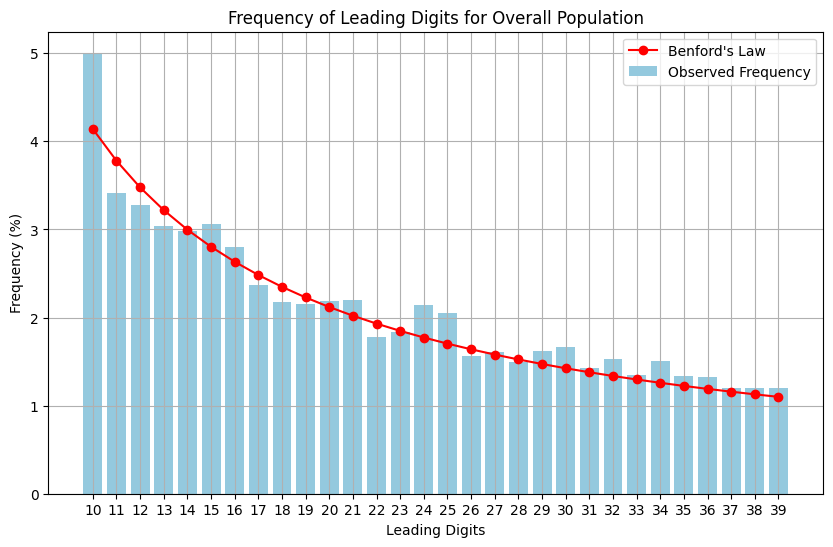

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(data=ben_pop, x='leading_digits', y='actual_frequency', color='skyblue', label='Observed Frequency')

# Add line plot for Benford probabilities
plt.plot(ben_pop['leading_digits'], ben_pop['benford_p'], color='red', marker='o', label='Benford\'s Law')

# Customize plot
plt.title('Frequency of Leading Digits for Overall Population')
plt.xlabel('Leading Digits')
plt.ylabel('Frequency (%)')
plt.legend()
plt.grid(True)
# plt.tight_layout()

# Show plot
plt.show()

In [31]:
ben_pop.head(5)

,leading_digits,actual_frequency,benford_p,z_score
0,10,4.993855,4.139269,9.713505
1,11,3.407916,3.778856,-4.404436
2,12,3.277217,3.476211,-2.459631
4,13,3.043131,3.218468,-2.249348
5,14,2.978757,2.996322,-0.233281


In [32]:
ben_pop = leading_digit_frequency_no_group(df_updated_2, ['DebitAmount_GLEntry', 'CreditAmount_GLEntry'])
df_updated_3 = df_updated_2.copy()
df_updated_3['combined_value'] = df_updated_3.apply(lambda row: row['DebitAmount_GLEntry'] if row['DebitAmount_GLEntry'] != 0 else row['CreditAmount_GLEntry'], axis=1)

# Extract first two digits
df_updated_3['leading_digits'] = df_updated_3['combined_value'].astype(str).str.replace(r'\D', '', regex=True).str[:2]
df_updated_3.columns

Index(['CompanyName', 'ExcludeBalanceOnly', 'PrintReversedEntries',
       'PageGroupNo', 'PrintOnlyOnePerPage', 'PrintClosingEntries',
       'PrintOnlyCorrections', 'EmptyString', 'No_GLAcc',
       'DetailTrialBalCaption', 'PageCaption', 'BalanceCaption',
       'PeriodCaption', 'OnlyCorrectionsCaption', 'NetChangeCaption',
       'GLEntryDebitAmtCaption', 'GLEntryCreditAmtCaption', 'GLBalCaption',
       'Name_GLAcc', 'StartBalance', 'VATAmount_GLEntry',
       'DebitAmount_GLEntry', 'CreditAmount_GLEntry', 'PostingDate_GLEntry',
       'DocumentNo_GLEntry', 'ExtDocNo_GLEntry', 'Description_GLEntry',
       'GLBalance', 'EntryNo_GLEntry', 'ClosingEntry', 'Reversed_GLEntry',
       'DQ_Mismatch_JE_Amt', 'DQ_Negative_Credit', 'DQ_Negative_Debit',
       'DQ_Missing_COA', 'DQ_Missing_Des', 'DQ_one_holiday', 'DQ_Duplicates',
       'Dup_JE_Same_GLAcc_Date_Amt', 'Dup_JE_Same_Description_GLAcc_Amt',
       'DQ_Negative_Credit_or_Debit', 'Document_type', 'NO_OF_JE_LINES',
       'NO_OF_GL

In [33]:
df_merged = df_updated_3.merge(ben_pop, on='leading_digits', how='left')
df_merged.head(5)

,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,DetailTrialBalCaption,...,avg_days_in_week,je_frequency,je_%_frequency,infrequent_w,Total_JE_Amt_trailing0s,combined_value,leading_digits,actual_frequency,benford_p,z_score
0,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,7.0,62.285714,25.425958,0,0,124788.0,12,3.277217,3.476211,-2.459631
1,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,7.0,62.285714,25.425958,0,0,6885.0,68,0.532548,0.634018,-2.894476
2,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,7.0,11.714286,28.412782,0,0,6615.0,66,0.690557,0.653087,1.053225
3,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,7.0,62.285714,25.425958,0,0,343369.0,34,1.511812,1.258913,5.135730
4,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,7.0,11.714286,28.412782,0,0,329904.0,32,1.533270,1.336396,3.881889


In [34]:
# Number of JEs with 10 in their entries
df_updated_3[df_updated_3['leading_digits']=='10']['combined_value'].value_counts()
df_updated_3[df_updated_3['combined_value'] == 1.0]['JE_Doc_ID'].value_counts()

JE_Doc_ID
Hailong3|FX202301|2023-01-31      4
Hailong3|GJ22100128|2022-10-31    3
Hailong2|GJ22100383|2022-10-31    3
Hailong3|GJ24030100|2024-03-08    3
Hailong3|GJ24010076|2024-01-10    3
                                 ..
Hailong2|GJ24050564|2024-05-10    1
Hailong3|GJ23010142|2023-01-18    1
Hailong3|GJ23010148|2023-01-18    1
Hailong2|GJ23070540|2023-07-26    1
Hailong3|GJ24050253|2024-05-02    1
Name: count, Length: 317, dtype: int64

### Within cluster

In [35]:
def leading_digit_frequency(df, value_cols, group_col):
    """
    Computes the frequency of the first two leading digits from rows where
    exactly one of the columns in `value_cols` is non-zero, grouped by `group_col`.

    Parameters:
    - df: pandas DataFrame
    - value_cols: list of two column names to check
    - group_col: column to group by (e.g., cluster label)

    Returns:
    - A DataFrame with frequencies of leading digits per group
    """
    col1, col2 = value_cols

    # Identify rows where both columns are non-zero
    both_non_zero = df[(df[col1] != 0) & (df[col2] != 0)]
    if not both_non_zero.empty:
        print("⚠️ Warning: Found rows where both columns are non-zero:")
        print(both_non_zero[[group_col, col1, col2]])

    # Filter rows where exactly one column is non-zero
    df = df[((df[col1] != 0) & (df[col2] == 0)) | ((df[col1] == 0) & (df[col2] != 0))].copy()

    # Create a column with the non-zero value
    df['combined_value'] = df.apply(lambda row: row[col1] if row[col1] != 0 else row[col2], axis=1)

    # Extract first two digits
    df['leading_digits'] = df['combined_value'].astype(str).str.replace(r'\D', '', regex=True).str[:2]

    # Filter out invalid or short digit strings and exclude '00'
    df = df[df['leading_digits'].str.len() == 2]

    # Count occurrences per group and digit
    freq_df = df.groupby([group_col, 'leading_digits']).size().reset_index(name='count')

    # Normalize counts within each group
    freq_df['frequency'] = freq_df.groupby(group_col)['count'].transform(lambda x: x / x.sum()) * 100

    return freq_df.sort_values(by=[group_col, 'frequency'], ascending=[True, False])

ben = leading_digit_frequency(labeled_df, ['DebitAmount_GLEntry', 'CreditAmount_GLEntry'],'ClusterPattern')

In [36]:
labeled_df['ClusterPattern'].unique()
# ben[ben['ClusterPattern']==('Cr 20000000 ap - trade', 'Dr 16100000 construction in progress')]

array([('Cr 20000000 ap - trade', 'Dr 16100000 construction in progress'),
       ('Cr 16100001 construction in progress - proxy for cost control', 'Dr 16100000 construction in progress', 'Zero 20000000 ap - trade'),
       ('Cr 20000000 ap - trade', 'Dr 11080000 input vat', 'Dr 16100000 construction in progress'),
       ('Cr 10000020 cash on hands - eur', 'Dr 16100000 construction in progress'),
       ('Cr 2002YECL inter ap - yecl', 'Dr 11080000 input vat', 'Dr 16100000 construction in progress'),
       ('Cr 16100001 construction in progress - proxy for cost control', 'Dr 16100000 construction in progress', 'Zero 2002YECL inter ap - yecl'),
       ('Cr 20010010 ap - employee', 'Dr 11080000 input vat', 'Dr 16100000 construction in progress'),
       ('Cr 20010010 ap - employee', 'Dr 16100000 construction in progress', 'Dr 60040030 travel - transportation'),
       ('Cr 16100000 construction in progress', 'Dr 10000020 cash on hands - eur'),
       ('Cr 16100001 construction in progre

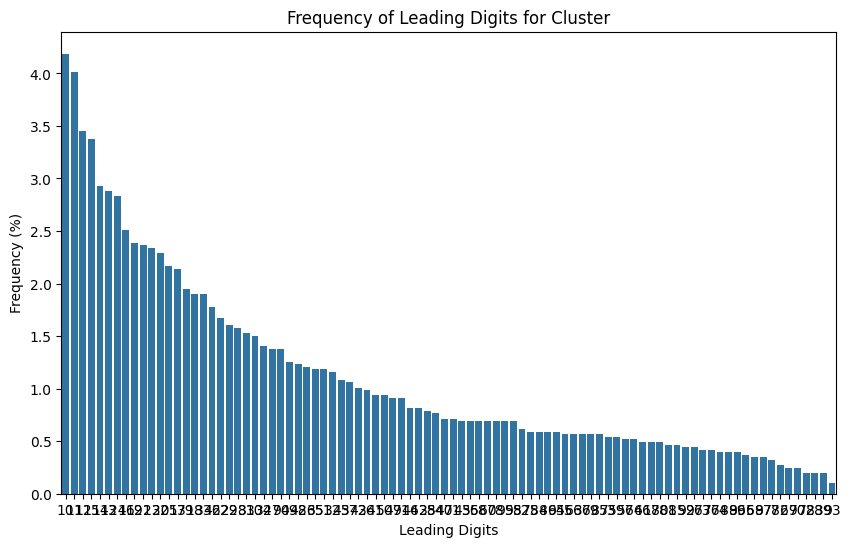

In [37]:
filtered_df = ben[ben['ClusterPattern']==('Cr 20000000 ap - trade', 'Dr 16100000 construction in progress')]
# filtered_df = ben[ben['ClusterPattern']==('Cr 20000000 ap - trade', 'Dr 16100000 construction in progress')]

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_df, x='leading_digits', y='frequency')

# Customize plot
plt.title(f'Frequency of Leading Digits for Cluster')
plt.xlabel('Leading Digits')
plt.ylabel('Frequency (%)')
# plt.tight_layout()

# Show plot
plt.show()

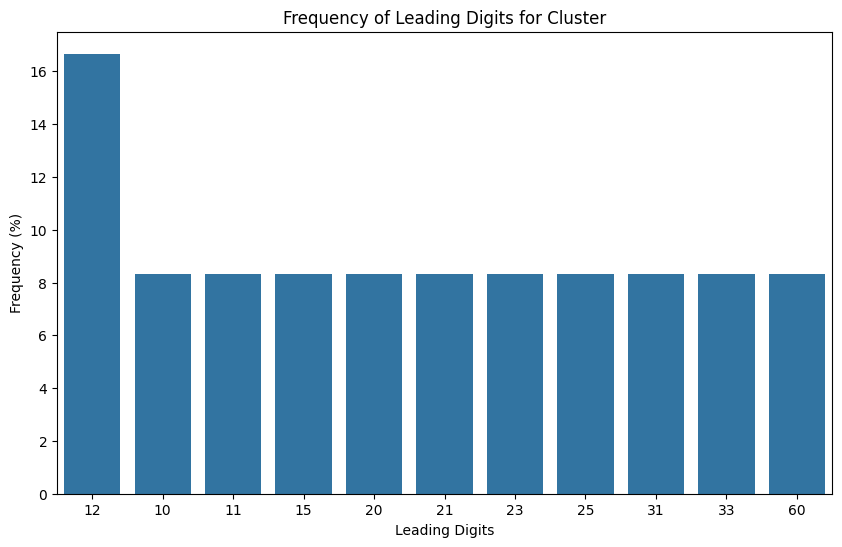

In [38]:
filtered_df = ben[ben['ClusterPattern']==('Cr 16100000 construction in progress', 'Cr 20040000 output vat', 'Dr 11000100 ar - others')]

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_df, x='leading_digits', y='frequency')

# Customize plot
plt.title(f'Frequency of Leading Digits for Cluster')
plt.xlabel('Leading Digits')
plt.ylabel('Frequency (%)')
# plt.tight_layout()

# Show plot
plt.show()

# Make JE raw dataframe<br>
Make a dataframe where data + new feature columns are grouped in journal document format (JE_Doc_ID). <br>Journal documents with all line entries = 0 are removed.

In [39]:
# df_updated_2['ClusterPattern'].nunique()
df_merged['ClusterPattern'].nunique()

725

In [40]:
je_raw = df_merged[df_merged['Total_JE_Amount'] != 0].copy()
je_raw['ClusterPattern'].nunique()

716

In [41]:
grouped_df = je_raw.groupby('JE_Doc_ID').agg(lambda x: list(x)).reset_index()
grouped_df

,JE_Doc_ID,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,...,avg_days_in_week,je_frequency,je_%_frequency,infrequent_w,Total_JE_Amt_trailing0s,combined_value,leading_digits,actual_frequency,benford_p,z_score
0,Hailong2|EX20221025|2022-10-25,"[Hailong2, Hailong2]","[FALSE, FALSE]","[FALSE, FALSE]","[1, 1]","[FALSE, FALSE]","[FALSE, FALSE]","[FALSE, FALSE]","[None, None]","[10000020, 70010000]",...,"[9.0, 9.0]","[0.2222222222222222, 0.2222222222222222]","[35.89743589743589, 35.89743589743589]","[0, 0]","[0, 0]","[1.0, 1.0]","[10, 10]","[4.993855217213195, 4.993855217213195]","[4.139268515822508, 4.139268515822508]","[9.713505043682245, 9.713505043682245]"
1,Hailong2|FX20221101|2022-11-29,"[Hailong2, Hailong2, Hailong2, Hailong2]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[1, 1, 1, 1]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[None, None, None, None]","[10000020, 10000020, 70010000, 70010000]",...,"[10.0, 10.0, 10.0, 10.0]","[0.1, 0.1, 0.1, 0.1]","[100.0, 100.0, 100.0, 100.0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[2060999820.0, 2026160321.0, 2060999820.0, 202...","[20, 20, 20, 20]","[2.192614556307668, 2.192614556307668, 2.19261...","[2.118929906993809, 2.118929906993809, 2.11892...","[1.158434226174428, 1.158434226174428, 1.15843..."
2,Hailong2|FX20221104|2022-11-30,"[Hailong2, Hailong2, Hailong2, Hailong2]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[1, 1, 1, 1]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[None, None, None, None]","[10000010, 10000010, 70010000, 70010000]",...,"[10.0, 10.0, 10.0, 10.0]","[0.1, 0.1, 0.1, 0.1]","[41.1764705882353, 41.1764705882353, 41.176470...","[0, 0, 0, 0]","[0, 0, 0, 0]","[46742247357.0, 46742247357.0, 46742247357.0, ...","[46, 46, 46, 46]","[1.0065739422195346, 1.0065739422195346, 1.006...","[0.9340026254143432, 0.9340026254143432, 0.934...","[1.7081682917159524, 1.7081682917159524, 1.708..."
3,Hailong2|FX20221201|2022-12-24,"[Hailong2, Hailong2]","[FALSE, FALSE]","[FALSE, FALSE]","[1, 1]","[FALSE, FALSE]","[FALSE, FALSE]","[FALSE, FALSE]","[None, None]","[10000020, 70010000]",...,"[7.0, 7.0]","[0.2857142857142857, 0.2857142857142857]","[46.15384615384615, 46.15384615384615]","[0, 0]","[0, 0]","[17505373.0, 17505373.0]","[17, 17]","[2.3740319528704914, 2.3740319528704914]","[2.4823583725032146, 2.4823583725032146]","[-1.5763859796129422, -1.5763859796129422]"
4,Hailong2|FX20221202|2022-12-24,"[Hailong2, Hailong2, Hailong2, Hailong2]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[1, 1, 1, 1]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[None, None, None, None]","[10000010, 10000010, 70010000, 70010000]",...,"[7.0, 7.0, 7.0, 7.0]","[0.14285714285714285, 0.14285714285714285, 0.1...","[58.82352941176471, 58.82352941176471, 58.8235...","[0, 0, 0, 0]","[0, 0, 0, 0]","[17814966.0, 17799975.0, 17814966.0, 17799975.0]","[17, 17, 17, 17]","[2.3740319528704914, 2.3740319528704914, 2.374...","[2.4823583725032146, 2.4823583725032146, 2.482...","[-1.5763859796129422, -1.5763859796129422, -1...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16950,Hailong3|GJ24050528|2024-05-31,"[Hailong3, Hailong3]","[FALSE, FALSE]","[FALSE, FALSE]","[1, 1]","[FALSE, FALSE]","[FALSE, FALSE]","[FALSE, FALSE]","[None, None]","[2002YECL, 16100000]",...,"[7.153846153846154, 7.153846153846154]","[1.8172043010752688, 1.8172043010752688]","[100.0, 100.0]","[0, 0]","[0, 0]","[12786275.0, 12786275.0]","[12, 12]","[3.277217486296159, 3.277217486296159]","[3.476210625921191, 3.476210625921191]","[-2.4596306161850903, -2.4596306161850903]"
16951,Hailong3|GJ24050529|2024-05-31,"[Hailong3, Hailong3, Hailong3, Hailong3]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[1, 1, 1, 1

In [42]:
def condense_uniform_lists(df):
    for col in df.columns:
        if col == 'JE_Doc_ID':
            continue  # Skip the grouping key
        df[col] = df[col].apply(lambda x: x[0] if len(set(x)) == 1 else x)
    return df

cleaned_df = condense_uniform_lists(grouped_df)
cleaned_df

,JE_Doc_ID,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,...,avg_days_in_week,je_frequency,je_%_frequency,infrequent_w,Total_JE_Amt_trailing0s,combined_value,leading_digits,actual_frequency,benford_p,z_score
0,Hailong2|EX20221025|2022-10-25,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000020, 70010000]",...,9.000000,0.222222,35.897436,0,0,1.0,10,4.993855,4.139269,9.713505
1,Hailong2|FX20221101|2022-11-29,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000020, 10000020, 70010000, 70010000]",...,10.000000,0.100000,100.000000,0,0,"[2060999820.0, 2026160321.0, 2060999820.0, 202...",20,2.192615,2.11893,1.158434
2,Hailong2|FX20221104|2022-11-30,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000010, 10000010, 70010000, 70010000]",...,10.000000,0.100000,41.176471,0,0,46742247357.0,46,1.006574,0.934003,1.708168
3,Hailong2|FX20221201|2022-12-24,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000020, 70010000]",...,7.000000,0.285714,46.153846,0,0,17505373.0,17,2.374032,2.482358,-1.576386
4,Hailong2|FX20221202|2022-12-24,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000010, 10000010, 70010000, 70010000]",...,7.000000,0.142857,58.823529,0,0,"[17814966.0, 17799975.0, 17814966.0, 17799975.0]",17,2.374032,2.482358,-1.576386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16950,Hailong3|GJ24050528|2024-05-31,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[2002YECL, 16100000]",...,7.153846,1.817204,100.000000,0,0,12786275.0,12,3.277217,3.476211,-2.459631
16951,Hailong3|GJ24050529|2024-05-31,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[20800000, 14020000, 30400000, 30400010]",...,8.333333,0.360000,100.000000,0,0,"[158487446.0, 792437227.0, 792437227.0, 158487...","[15, 79, 79, 15]","[3.0587363205430815, 0.47987827477908046, 0.47...","[2.8028723600243532, 0.5462895701502187, 0.546...","[3.5098030844188974, -2.0399616863081897, -2.0..."
16952,Hailong3|GJ24050530|2024-05-31,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[20800000, 14020000, 30400000, 30400010]",...,7.000000,0.428571,100.000000,0,0,"[166611020.0, 833055101.0, 833055101.0, 166611...","[16, 83, 83, 16]","[2.7992899362113026, 0.366736242514094, 0.3667...","[2.6328938722349147, 0.5201193685807723, 0.520...","[2.353001749523772, -4.82792431046737, -4.8279..."
16953,Hailong3|GJ24050531|2024-05-31,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[2060EDBS, 2060EDBS-I, 2060EMUFG, 2060EMUFG-I,...",...,5.000000,0.400000,100.000000,0,0,"[14228144.0, 14163877.0, 15454913.0, 15454913....","[14, 14, 15, 15, 71, 66, 64, 45]","[2.9787566080799017, 2.9787566080799017, 3.058...","[2.99632233774432, 2.99632233774432, 2.8028723...","[-0.2332812522512919, -0.2332812522512919, 3.5..."


In [ ]:
cleaned_df['Account_ID']

0        [10000020 cash on hands - eur, 70010000 foreig...
1        [10000020 cash on hands - eur, 10000020 cash o...
2        [10000010 cash on hands - usd, 10000010 cash o...
3        [10000020 cash on hands - eur, 70010000 foreig...
4        [10000010 cash on hands - usd, 10000010 cash o...
                               ...                        
16950    [2002YECL inter ap - yecl, 16100000 constructi...
16951    [20800000 deferred tax liabilities, 14020000 d...
16952    [20800000 deferred tax liabilities, 14020000 d...
16953    [2060EDBS bank loan - ebl dbs, 2060EDBS-I bank...
16954    [80100000 income taxes - deferred, 20800000 de...
Name: Account_ID, Length: 16955, dtype: object

In [ ]:
# # Define function to get max absolute z-score
# def max_abs_zscore(z):
#     if isinstance(z, list):
#         # return max([abs(i) for i in z if pd.notnull(i)])         # to return abs value of max ele in list
#         return max(z, key=lambda x: abs(x) if pd.notnull(x) else -np.inf)
#     elif pd.notnull(z):
#         return z
#     else:
#         return np.nan

# # Apply to cleaned_df
# cleaned_df['max_z_score'] = cleaned_df['z_score'].apply(max_abs_zscore)
# cleaned_df

## Make feature dataframe<br>
Make input dataframe (journal document format) to use in the ML algorithm

In [46]:
feature_cols = ['JE_Doc_ID','Cluster_ID', 'ClusterPattern','Total_Credit','Total_Debit','Total_JE_Amount',
               'WeekOfMonth', 'je_frequency', 'je_%_frequency', 'infrequent_w',
               'Total_JE_Amt_trailing0s']

features_df = cleaned_df[feature_cols]

In [47]:
features_df['ClusterPattern'].nunique()

716

# Isolation Forest

In [48]:
from sklearn.ensemble import IsolationForest
import shap
import lime
import lime.lime_tabular
from tqdm import tqdm
import warnings

def detect_anomalies_with_explanations(
    df: pd.DataFrame,
    features: list,
    thres: float = 0.1,
    use_shap: bool = True,
    use_lime: bool = True
) -> pd.DataFrame:
    """
    Detect anomalies within each Cluster_ID using Isolation Forest and explain 
    anomalies using SHAP and/or LIME.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Original dataframe with JE_Doc_ID and Cluster_ID
    features : list
        List of column names (numeric) to use for anomaly detection
    use_shap : bool
        Whether to compute SHAP values for explanations
    use_lime : bool
        Whether to compute LIME explanations for sample anomalies

    Returns:
    --------
    pd.DataFrame
        Original DataFrame with added columns:
        - 'is_anomaly': bool, 1 if anomaly
        - 'anomaly_score': float, raw anomaly score from Isolation Forest
        - 'anomaly_reason': str, top features contributing to anomaly
    """
    
    # Output columns
    result_df = df.copy().reset_index(drop=True)
    result_df['is_anomaly'] = 0
    result_df['anomaly_score'] = np.nan
    result_df['anomaly_reason'] = ""
    
    # Store LIME explainers per cluster (if needed)
    lime_explainers = {}
    
    # Suppress sklearn feature name warning
    def _silence_warning():
        warnings.filterwarnings(
            "ignore", 
            message="X does not have valid feature names", 
            category=UserWarning
        )
    _silence_warning()

    # Iterate over each Cluster_ID
    cluster_ids = df['Cluster_ID'].unique()
    
    for cluster_id in tqdm(cluster_ids, desc="Processing Clusters"):
        cluster_mask = df['Cluster_ID'] == cluster_id
        cluster_data = df[cluster_mask].copy()
        
        # Skip if not enough data
        if len(cluster_data) < 2:
            continue
        
        X = cluster_data[features]
        
        # 1. Apply Isolation Forest
        iso_forest = IsolationForest(contamination=thres, random_state=42, n_estimators=100)
        iso_forest.fit(X)
        
        # Anomaly scores
        scores = iso_forest.decision_function(X.values)  # Use .values to avoid feature name warning
        anomaly_preds = iso_forest.predict(X.values)     # Same here
        
        # Map back to original indices
        cluster_indices = cluster_data.index
        result_df.loc[cluster_indices, 'anomaly_score'] = scores
        result_df.loc[cluster_indices, 'is_anomaly'] = (anomaly_preds == -1).astype(int)
        
        # 2. Explain anomalies using SHAP (and LIME if requested)
        shap_values = None
        explainer = None
        lime_explainer = None
        
        if use_shap:
            try:
                # Remove 'check_additivity' — not supported in newer SHAP versions
                explainer = shap.TreeExplainer(
                    iso_forest, 
                    feature_names=features  # Removed check_additivity
                )
                shap_values_raw = explainer.shap_values(X.values)
                
                # Handle output: IsolationForest may return list or array
                if isinstance(shap_values_raw, list):
                    shap_values = np.abs(shap_values_raw[0])  # Use first output
                else:
                    shap_values = np.abs(shap_values_raw)
                    
            except Exception as e:
                print(f"SHAP explanation failed for Cluster_ID {cluster_id}: {e}")
                shap_values = None
        
        if use_lime and len(cluster_data) <= 500:  # Limit LIME to smaller clusters
            try:
                def prediction_fn(x):
                    if x.ndim == 1:
                        x = x.reshape(1, -1)
                    return iso_forest.decision_function(x)
                
                lime_explainer = lime.lime_tabular.LimeTabularExplainer(
                    X.values,
                    feature_names=features,
                    class_names=['anomaly_score'],
                    mode='regression',
                    random_state=42
                )
                lime_explainers[cluster_id] = (lime_explainer, prediction_fn)
            except Exception as e:
                print(f"LIME setup failed for Cluster_ID {cluster_id}: {e}")
        
        # 3. Generate anomaly_reason for each anomalous entry
        for idx in cluster_indices:
            if result_df.loc[idx, 'is_anomaly'] == 1:
                local_reasons = []
                
                # Use SHAP if available
                if use_shap and shap_values is not None:
                    row_pos = list(cluster_indices).index(idx)
                    shap_row = shap_values[row_pos]
                    top_feats_idx = np.argsort(-shap_row)[:2]
                    top_feats = [features[i] for i in top_feats_idx]
                    local_reasons.append("SHAP: " + ", ".join(top_feats))
                
                # Use LIME if available
                if use_lime and cluster_id in lime_explainers:
                    try:
                        lime_explainer, pred_fn = lime_explainers[cluster_id]
                        row_pos = list(cluster_indices).index(idx)
                        x = X.iloc[row_pos].values
                        exp = lime_explainer.explain_instance(
                            x, pred_fn, num_features=2, num_samples=50
                        )
                        lime_reasons = [item[0] for item in exp.as_list()]
                        if lime_reasons:
                            local_reasons.append("LIME: " + ", ".join(lime_reasons))
                    except Exception as e:
                        print(f"LIME failed for JE_Doc_ID {df.loc[idx, 'JE_Doc_ID']}: {e}")
                        pass
                
                # Combine reasons
                reason_str = "; ".join(local_reasons) if local_reasons else "High overall deviation"
                result_df.loc[idx, 'anomaly_reason'] = reason_str
    
    return result_df

In [49]:
features = ['Total_JE_Amount', 'infrequent_w', 'Total_JE_Amt_trailing0s']

print(features)
# result = detect_anomalies_with_explanations(df_updated_2, features=features, thres=0.1, use_shap=True, use_lime=True)
result_2 = detect_anomalies_with_explanations(features_df, features=features, thres=0.01, use_shap=True, use_lime=True)

['Total_JE_Amount', 'infrequent_w', 'Total_JE_Amt_trailing0s']


Processing Clusters: 100%|██████████| 716/716 [01:29<00:00,  7.96it/s]


In [50]:
cols_to_add = [col for col in result_2.columns if col not in cleaned_df.columns]
# result = df_updated_2.merge(result_2[['JE_Doc_ID']+cols_to_add], on='JE_Doc_ID', how='left')
result = cleaned_df.merge(result_2[['JE_Doc_ID']+cols_to_add], on='JE_Doc_ID', how='left')
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16955 entries, 0 to 16954
Data columns (total 74 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   JE_Doc_ID                               16955 non-null  object 
 1   CompanyName                             16955 non-null  object 
 2   ExcludeBalanceOnly                      16955 non-null  object 
 3   PrintReversedEntries                    16955 non-null  object 
 4   PageGroupNo                             16955 non-null  int64  
 5   PrintOnlyOnePerPage                     16955 non-null  object 
 6   PrintClosingEntries                     16955 non-null  object 
 7   PrintOnlyCorrections                    16955 non-null  object 
 8   EmptyString                             0 non-null      object 
 9   No_GLAcc                                16955 non-null  object 
 10  DetailTrialBalCaption                   16955 non-null  ob

In [51]:
clusters = sorted(
    result[result['anomaly_score'].isnull()]['Cluster_ID'].unique(),
    key=lambda x: int(x) if str(x).isdigit() else float('inf')
)
count = 0
for cluster in clusters:
    je_count = result[result['Cluster_ID']==cluster]['JE_Doc_ID'].nunique()
    if je_count == 1:
        # print(f'Cluster ID {cluster} only has 1 JE inside')
        count+=1
        result.loc[(result['Cluster_ID']==cluster) & (result['anomaly_reason'] == ''), 'anomaly_reason']='Cluster has only 1 JE inside'
    else:
        print(f'Cluster ID {cluster} has {result[result['Cluster_ID']==cluster]['JE_Doc_ID'].nunique()} JE inside')

print(f'{count} clusters have 1 JE inside')

277 clusters have 1 JE inside


In [52]:
result[result['anomaly_score'].isnull()]['anomaly_reason'].unique()

array(['Cluster has only 1 JE inside'], dtype=object)

## Percentile reason

In [53]:
# More flexible bins depending on distribution

def get_percentile_range_str(cluster_data, feature, value, min_bin_width=5, max_bins=10):
    """
    Compute the percentile range that a value falls into within cluster_data[feature],
    using adaptive binning based on data distribution. The binning prioritizes resolution
    where data is dense around the value.

    Parameters:
    - cluster_data: DataFrame containing the data
    - feature: column name (str)
    - value: query value
    - min_bin_width: minimum width (in percentile) for a bin (default 5%)
    - max_bins: maximum number of bins to consider (default 10)

    Returns:
    - String describing the percentile range or exact match.
    """
    data = np.array(cluster_data[feature].values)
    total = len(data)
    
    if total == 0:
        return f"{feature} (no data)"

    # Handle edge case: all values are identical
    if np.all(data == data[0]):
        if data[0] == value:
            return f"{feature} (all values are {value})"
        else:
            # Value not present; find closest percentile
            pct = 50.0  # Represented as middle since all same
            return f"{feature} ({pct:.0f}th percentile neighborhood)"

    # Compute percentiles of interest around the value
    sorted_vals = np.sort(data)
    
    # Percentile rank of values strictly less than `value`
    lower_pct = 100 * np.searchsorted(sorted_vals, value, side='left') / total
    # Percentile rank of values <= `value`
    upper_pct = 100 * np.searchsorted(sorted_vals, value, side='right') / total

    # Exact match handling
    if lower_pct == upper_pct:
        return f"{feature} (exact match at {upper_pct:.0f}th percentile)"
    
    # All values equal to target
    if lower_pct == 0 and upper_pct == 100:
        return f"{feature} (all values are {value})"

    # We now aim to create adaptive bins focused around [lower_pct, upper_pct]
    center = (lower_pct + upper_pct) / 2

    # Decide candidate breakpoints adaptively:
    # Use quantiles to sample points across the data, with emphasis near `center`
    q_min = max(0, center - 25)   # Look from 25% below center
    q_max = min(100, center + 25) # to 25% above

    # Generate base linear percentiles
    base_percentiles = np.linspace(0, 100, max_bins + 1)

    # Add extra resolution near center
    local_percentiles = np.linspace(q_min, q_max, 6)  # higher res around center
    all_percentiles = np.unique(np.sort(np.concatenate([base_percentiles, local_percentiles])))

    # Trim to valid range
    all_percentiles = all_percentiles[(all_percentiles >= 0) & (all_percentiles <= 100)]

    # Build bins from these percentiles
    bins = []
    for i in range(len(all_percentiles) - 1):
        start = all_percentiles[i]
        end = all_percentiles[i + 1]
        if (end - start) < min_bin_width:
            continue
        bins.append((start, end))

    # Now find which bin contains any part of [lower_pct, upper_pct]
    for start, end in bins:
        if lower_pct < end and upper_pct >= start:
            # Format nice ordinal suffix
            def ordinal(n):
                if 10 <= n % 100 <= 20:
                    suffix = 'th'
                else:
                    suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
                return f"{int(n)}{suffix}"

            # Prefer showing integer bounds
            start_int = int(round(start))
            end_int = int(round(end))
            if start_int == end_int:
                return f"{feature} ({ordinal(start_int)} percentile neighborhood)"
            return f"{feature} ({start_int}th–{end_int}th percentile)"

    # Fallback
    if upper_pct > 99.9:
        return f"{feature} (100th percentile)"
    elif lower_pct < 0.1:
        return f"{feature} (0th percentile)"
    else:
        mid = (lower_pct + upper_pct) / 2
        return f"{feature} (~{mid:.0f}th percentile)"

In [54]:
def add_percentile_explanation(
    result_df: pd.DataFrame,
    features: list
) -> pd.DataFrame:
    """
    Adds percentile information for features cited in 'anomaly_reason'
    to explain how extreme they are within their cluster.

    Parameters:
    -----------
    result_df : pd.DataFrame
        Output from detect_anomalies_with_explanations(), must have:
        - 'Cluster_ID', 'anomaly_reason', and original feature columns
    features : list
        List of numeric feature names used in modeling

    Returns:
    --------
    pd.DataFrame
        Same as input, with new column:
        - 'anomaly_reason_with_percentiles': str, e.g., "Amount (97th percentile); Count (10th)"
    """
    df = result_df.copy()

    # New column to store enhanced explanation
    df['anomaly_reason_with_percentiles'] = ""    

    for cluster_id in df['Cluster_ID'].unique():
        cluster_mask = df['Cluster_ID'] == cluster_id
        cluster_data = df[cluster_mask]

        # Skip if no anomalies or too few points
        if len(cluster_data) == 0:
            continue

        for idx in cluster_data.index:
            if df.loc[idx, 'is_anomaly'] == 1:
                reason = df.loc[idx, 'anomaly_reason']
                if not reason or reason == "" or "High overall deviation" in reason:
                    df.loc[idx, 'anomaly_reason_with_percentiles'] = reason
                    continue

                explained_features = []
                # Extract features mentioned by SHAP or LIME
                # Format like: "SHAP: A, B; LIME: B, C"
                for part in reason.split(";"):
                    if ":" in part:
                        method, feats = part.split(":", 1)
                        feat_list = [f.strip() for f in feats.split(",")]
                        explained_features.extend(feat_list)

                # Remove duplicates while preserving order
                seen = set()
                unique_features = [f for f in explained_features if not (f in seen or seen.add(f))]

                # Now get percentile for each cited feature
                pct_descriptions = []
                for feat in unique_features:
                    if feat not in features:
                        continue
                    val = df.loc[idx, feat]
                    # pct_str = get_percentile_str(cluster_data, feat, val)
                    pct_str = get_percentile_range_str(cluster_data, feat, val)
                    pct_descriptions.append(pct_str)

                # Join all percentile explanations
                final_reason = "; ".join(pct_descriptions)
                df.loc[idx, 'anomaly_reason_with_percentiles'] = final_reason

    return df

In [55]:
# features = ['Total_JE_Amount', 'je_frequency']
result = add_percentile_explanation(result, features=features)

In [56]:
result['anomaly_reason_with_percentiles'].unique()

array(['',
       'infrequent_w (95th–100th percentile); Total_JE_Amt_trailing0s (60th–68th percentile)',
       'Total_JE_Amount (94th–100th percentile); Total_JE_Amt_trailing0s (0th–10th percentile)',
       'Total_JE_Amount (80th–86th percentile); infrequent_w (all values are 0)',
       'Total_JE_Amt_trailing0s (95th–100th percentile); Total_JE_Amount (43th–50th percentile)',
       'Total_JE_Amount (95th–100th percentile); Total_JE_Amt_trailing0s (31th–40th percentile)',
       'Total_JE_Amount (0th–8th percentile); infrequent_w (all values are 0)',
       'Total_JE_Amount (70th–78th percentile); Total_JE_Amt_trailing0s (0th–10th percentile)',
       'Total_JE_Amount (0th–6th percentile); infrequent_w (all values are 0)',
       'Total_JE_Amount (94th–100th percentile); infrequent_w (all values are 0)',
       'Total_JE_Amount (95th–100th percentile); Total_JE_Amt_trailing0s (0th–10th percentile)',
       'Total_JE_Amt_trailing0s (80th–86th percentile); Total_JE_Amount (20th–25th 

## Saving raw

In [57]:
# Map results back to Raw data
cols_to_add = [col for col in result.columns if col not in je_raw.columns]
raw_result = je_raw.merge(result[['JE_Doc_ID']+cols_to_add], on='JE_Doc_ID', how='left')
raw_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51680 entries, 0 to 51679
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   CompanyName                             51680 non-null  object 
 1   ExcludeBalanceOnly                      51680 non-null  object 
 2   PrintReversedEntries                    51680 non-null  object 
 3   PageGroupNo                             51680 non-null  int64  
 4   PrintOnlyOnePerPage                     51680 non-null  object 
 5   PrintClosingEntries                     51680 non-null  object 
 6   PrintOnlyCorrections                    51680 non-null  object 
 7   EmptyString                             0 non-null      object 
 8   No_GLAcc                                51680 non-null  object 
 9   DetailTrialBalCaption                   51680 non-null  object 
 10  PageCaption                             51680 non-null  ob

# PCA<br>
Process:
<ol>
<li>Apply PCA on data in each cluster</li>
<li>Reconstruct PCA applied data to get reconstruction error</li>
<li>Use reconstruction error as anomaly score to find anomalies</li>
<li>Get points with reconstruction errors > {specified threshold} % of reconstruction errors</li>
<li>Explain why point is anomalous by comparing reconstructed value with original value (too high or low) </li>
</ol>

In [58]:
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings
import numpy as np
import pandas as pd

def detect_anomalies_by_cluster_pca_with_percentiles(
    df: pd.DataFrame,
    features: list,
    thres: float = 2.5
) -> pd.DataFrame:
    """
    Detect anomalies within each Cluster_ID using PCA (no scaling).
    Anomalies based on reconstruction error.
    Explains why via residual analysis + percentile context.

    Parameters:
    -----------
    df : pd.DataFrame
        Must contain 'JE_Doc_ID', 'Cluster_ID', and numeric columns in `features`
    features : list of str
        List of numeric feature column names

    Returns:
    --------
    pd.DataFrame
        Original DataFrame with:
        - 'is_anomaly': bool
        - 'anomaly_score': reconstruction error
        - 'anomaly_reason': e.g., "Amount (too high, 97th percentile)"
        - Optionally keep original reason without percentiles if needed
    """
    
    # Suppress warnings
    warnings.filterwarnings("ignore", message="invalid value encountered in divide", category=RuntimeWarning)
    warnings.filterwarnings("ignore", message="X does not have valid feature names", category=UserWarning)

    result_df = df.copy().reset_index(drop=True)
    result_df['is_anomaly'] = False
    result_df['anomaly_score'] = np.nan
    result_df['anomaly_reason'] = ""
    result_df['anomaly_reason_raw'] = ""  # Optional: store raw direction before percentiles

    EPS = 1e-8

    grouped = df.groupby('Cluster_ID')
    print(f"Processing {len(grouped)} unique Cluster_IDs...")

    for cluster_id, group in tqdm(grouped, desc="Processing Clusters"):
        cluster_mask = df['Cluster_ID'] == cluster_id
        X = group[features].copy()
        n_samples, n_features = X.shape

        # Skip small clusters
        if n_samples < 2:
            result_df.loc[cluster_mask, ['anomaly_score', 'is_anomaly', 'anomaly_reason']] = (
                0.0, False, "Single entry in cluster"
            )
            continue

        # Handle missing data
        if X.isna().all().any():
            result_df.loc[cluster_mask, 'anomaly_reason'] = "Missing feature data"
            result_df.loc[cluster_mask, 'anomaly_score'] = 0.0
            continue
        X.fillna(0, inplace=True)  # or use median per cluster

        # Check variance
        feature_var = X.var(axis=0)
        total_var = feature_var.sum()

        if total_var < EPS:
            result_df.loc[cluster_mask, ['anomaly_score', 'is_anomaly', 'anomaly_reason']] = (
                0.0, False, "All values constant in cluster"
            )
            continue

        valid_features = feature_var[feature_var > EPS].index.tolist()
        if len(valid_features) == 0:
            result_df.loc[cluster_mask, 'anomaly_reason'] = "No varying features"
            result_df.loc[cluster_mask, 'anomaly_score'] = 0.0
            continue

        X_reduced = X[valid_features].values

        try:
            # --- PCA Transformation ---
            n_components = min(len(valid_features), n_samples - 1)
            pca = PCA(n_components=n_components)
            X_pca = pca.fit_transform(X_reduced)
            X_reconstructed = pca.inverse_transform(X_pca)

            # Reconstruct full space including dropped features
            if len(valid_features) < n_features:
                X_reconstructed_full = np.zeros((n_samples, n_features))
                for i, col in enumerate(features):
                    if col in valid_features:
                        idx_in_reduced = valid_features.index(col)
                        X_reconstructed_full[:, i] = X_reconstructed[:, idx_in_reduced]
                X_reconstructed = X_reconstructed_full

            # Compute reconstruction error
            reconstruction_error = np.sum((X.values - X_reconstructed) ** 2, axis=1)
            result_df.loc[cluster_mask, 'anomaly_score'] = reconstruction_error

            # Threshold: top 2.5%
            up = 100-thres
            # print(up)
            upper_bound = np.percentile(reconstruction_error, up)
            is_anom = reconstruction_error > upper_bound
            result_df.loc[cluster_mask, 'is_anomaly'] = is_anom

            # Residuals for explanation
            residuals = np.abs(X.values - X_reconstructed)

            # Precompute percentiles for all features in this cluster
            cluster_percentiles = {}
            for f in features:
                sorted_vals = np.sort(X[f].values)
                def percentile_of_value(val):
                    return 100 * np.mean(sorted_vals <= val)  # Fast approximate percentile
                cluster_percentiles[f] = np.array([percentile_of_value(x) for x in X[f]])

            # Explain each anomaly
            for idx_in_group, je_doc_id in enumerate(group['JE_Doc_ID']):
                row_idx = group.index[idx_in_group]
                res_row = residuals[idx_in_group]

                if is_anom[idx_in_group]:
                    # Top 2 features with highest absolute residual
                    top_indices = np.argsort(-res_row)[:2]
                    explanations = []

                    for i in top_indices:
                        feat = features[i]
                        orig_val = X.iloc[idx_in_group][feat]
                        recon_val = X_reconstructed[idx_in_group][i]
                        pct = cluster_percentiles[feat][idx_in_group]

                        direction = "high" if orig_val > recon_val + EPS else "low" if orig_val < recon_val - EPS else "deviant"

                        # Format: "Amount (too high, 97th percentile)"
                        explanations.append(f"{feat} (too {direction}, {pct:.0f}th percentile)")

                    reason_str = ", ".join(explanations)
                else:
                    reason_str = "Normal pattern"

                result_df.loc[row_idx, 'anomaly_reason'] = reason_str
                result_df.loc[row_idx, 'anomaly_reason_raw'] = ", ".join([
                    f"{features[i]} (too {'high' if X.iloc[idx_in_group][features[i]] > X_reconstructed[idx_in_group][i] else 'low'})"
                    for i in np.argsort(-residuals[idx_in_group])[:2]
                ])

        except Exception as e:
            print(f"PCA failed for Cluster_ID {cluster_id}: {e}")
            result_df.loc[cluster_mask, 'anomaly_reason'] = "PCA error"
            result_df.loc[cluster_mask, 'anomaly_score'] = 0.0
            continue

    print("✅ PCA-based anomaly detection with percentile explanations completed.")
    return result_df

In [59]:
# features = ['Total_JE_Amount', 'WeekOfMonth']
print(features)
# pca_result = detect_anomalies_by_cluster_pca(df=df_updated, features=features)
# pca_result = detect_anomalies_by_cluster_pca(df=df_updated_2, features=features)
pca_result_2 = detect_anomalies_by_cluster_pca_with_percentiles(df=features_df, features=features, thres=5)
# thres = top %

['Total_JE_Amount', 'infrequent_w', 'Total_JE_Amt_trailing0s']
Processing 716 unique Cluster_IDs...


Processing Clusters: 100%|██████████| 716/716 [00:08<00:00, 84.05it/s] 

✅ PCA-based anomaly detection with percentile explanations completed.


In [60]:
cols_to_add = [col for col in pca_result_2.columns if col not in df_updated_2.columns]
pca_result = cleaned_df.merge(pca_result_2[['JE_Doc_ID']+cols_to_add], on='JE_Doc_ID', how='left')
# pca_result = df_updated_2.merge(pca_result_2[['JE_Doc_ID']+cols_to_add], on='JE_Doc_ID', how='left')
pca_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16955 entries, 0 to 16954
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   JE_Doc_ID                               16955 non-null  object 
 1   CompanyName                             16955 non-null  object 
 2   ExcludeBalanceOnly                      16955 non-null  object 
 3   PrintReversedEntries                    16955 non-null  object 
 4   PageGroupNo                             16955 non-null  int64  
 5   PrintOnlyOnePerPage                     16955 non-null  object 
 6   PrintClosingEntries                     16955 non-null  object 
 7   PrintOnlyCorrections                    16955 non-null  object 
 8   EmptyString                             0 non-null      object 
 9   No_GLAcc                                16955 non-null  object 
 10  DetailTrialBalCaption                   16955 non-null  ob

In [61]:
pca_raw = je_raw.merge(pca_result_2[['JE_Doc_ID']+cols_to_add], on='JE_Doc_ID', how='left')
pca_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51680 entries, 0 to 51679
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   CompanyName                             51680 non-null  object 
 1   ExcludeBalanceOnly                      51680 non-null  object 
 2   PrintReversedEntries                    51680 non-null  object 
 3   PageGroupNo                             51680 non-null  int64  
 4   PrintOnlyOnePerPage                     51680 non-null  object 
 5   PrintClosingEntries                     51680 non-null  object 
 6   PrintOnlyCorrections                    51680 non-null  object 
 7   EmptyString                             0 non-null      object 
 8   No_GLAcc                                51680 non-null  object 
 9   DetailTrialBalCaption                   51680 non-null  object 
 10  PageCaption                             51680 non-null  ob

# Comparing

In [62]:
# Step 1: Filter for anomalies
anomalies_isf = result[result['is_anomaly'].isin([1, True])]
anomalies_pca = pca_result[pca_result['is_anomaly'].isin([1, True])]

# Step 2: Extract unique JE_Doc_IDs
ids_df1 = set(anomalies_isf['JE_Doc_ID'].unique())
ids_df2 = set(anomalies_pca['JE_Doc_ID'].unique())

# Step 3: Find common IDs
common_ids = ids_df1.intersection(ids_df2)

# Optional: Convert to list or DataFrame
common_ids_list = list(common_ids)
print(len(common_ids_list))

92


In [63]:
# Assuming you already have your DataFrame (e.g., df)
# And common_ids_list is defined

result['ISF_PCA_anomalies'] = result['JE_Doc_ID'].apply(lambda x: 1 if x in common_ids_list else 0)
pca_result['ISF_PCA_anomalies'] = pca_result['JE_Doc_ID'].apply(lambda x: 1 if x in common_ids_list else 0)
# pca_result[pca_result['ISF_PCA_anomalies']==1]['JE_Doc_ID'].nunique()

# Saving<br>
Results saved into <b>Acc_pairing_cluster.xlsx</b>. Sheets are edited to highlight feature columns and hide unnecessary columns

In [64]:
cols_to_add = ['ClusterPattern',
'Week1_je_%_frequency',
'Week2_je_%_frequency',
'Week3_je_%_frequency',
'Week4_je_%_frequency'
]

print(cols_to_add)
result = result.merge(freq_df[cols_to_add], on='ClusterPattern', how='left')
result

raw_result = raw_result.merge(freq_df[cols_to_add], on="ClusterPattern", how='left')

['ClusterPattern', 'Week1_je_%_frequency', 'Week2_je_%_frequency', 'Week3_je_%_frequency', 'Week4_je_%_frequency']


In [ ]:
from openpyxl import load_workbook

# Please edit file path (if needed)
file_path = rf"D:\Shared\Internal Dev - JE ML\Hailong\Acc_pairing_cluster.xlsx"
result.to_excel(file_path, sheet_name='ISF_result_je')

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    raw_result.to_excel(writer, sheet_name='ISF_result_raw', index=False)

print("ISF Cluster metrics sheet added successfully!")
# 1.5 mins

Exception ignored in: <function ZipFile.__del__ at 0x000001C70F9AF880>
Traceback (most recent call last):
  File "c:\Program Files\Python313\Lib\zipfile\__init__.py", line 1980, in __del__
    self.close()
  File "c:\Program Files\Python313\Lib\zipfile\__init__.py", line 1997, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


ISF Cluster metrics sheet added successfully!


In [66]:
# Step 2: Extract account names from each tuple
def extract_accounts(tup):
    accounts = []
    for entry in tup:
        parts = entry.split()
        account = ' '.join(parts[1:])  # Skip 'Cr/Dr' and amount
        accounts.append(account)
    return accounts

def create_cluster_metrics(df_in):
    total_unique_docs = df_in['JE_Doc_ID'].nunique()
    total_anomalies = df_in[df_in['is_anomaly'] == True]['JE_Doc_ID'].nunique()
    grouped = df_in.groupby(['Cluster_ID','ClusterPattern'])
    # Aggregate metrics
    cluster_metrics = grouped.apply(lambda df: pd.Series({
        'Cluster_Population': df['JE_Doc_ID'].nunique(),
        'Cluster_Anomalies': df[df['is_anomaly'] == True]['JE_Doc_ID'].nunique(),
        'ISF_PCA_Anomalies Count': df[df['ISF_PCA_anomalies']==1]['JE_Doc_ID'].nunique(),
    })).reset_index()

    # Calculate percentages
    cluster_metrics = cluster_metrics.sort_values(by='Cluster_Population', ascending=False).reset_index(drop=True)
    cluster_metrics['Cluster_Population (%)'] = cluster_metrics['Cluster_Population'] / total_unique_docs * 100
    cluster_metrics['Cluster_Population (%) - Cummulative'] = cluster_metrics['Cluster_Population (%)'].cumsum()

    cluster_metrics['Percentage of anomalies in Cluster'] = cluster_metrics['Cluster_Anomalies'] / cluster_metrics['Cluster_Population'] * 100
    cluster_metrics['Percentage of total anomalies in Cluster'] = cluster_metrics['Cluster_Anomalies'] / total_anomalies * 100

    # Get unique accounts
    cluster_metrics['accs'] = cluster_metrics['ClusterPattern'].apply(extract_accounts)
    cluster_metrics['Unique_accounts'] = cluster_metrics['accs'].apply(set)
    cluster_metrics['Num_unique_accs']=cluster_metrics['Unique_accounts'].apply(len)
    cluster_metrics=cluster_metrics.drop(columns=['accs'])

    # Create a summary row
    summary_row = pd.DataFrame([{
        'Cluster_ID': 'Total',
        'ClusterPattern':'',
        'Cluster_Population': cluster_metrics['Cluster_Population'].sum(),
        'Cluster_Anomalies': cluster_metrics['Cluster_Anomalies'].sum(),
        'ISF_PCA_Anomalies Count':cluster_metrics['ISF_PCA_Anomalies Count'].sum(),
        'Cluster_Population (%)': '',
        'Cluster_Population (%) - Cummulative': '',
        'Percentage of anomalies in Cluster': '',
        'Percentage of total anomalies in Cluster': '',
        'Unique_accounts': '',
        'Num_unique_accs': '',
    }])

    # Append to the bottom of the DataFrame
    cluster_metrics_with_total = pd.concat([cluster_metrics, summary_row], ignore_index=True)

    return cluster_metrics_with_total

In [67]:
from openpyxl import load_workbook

cluster_metrics_with_total = create_cluster_metrics(result)
# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    cluster_metrics_with_total.to_excel(writer, sheet_name='ISF_cluster_metrics', index=False)

print("ISF Cluster metrics sheet added successfully!")
# 1.5 mins

D:\victoriaquek\AppData\Local\Temp\9\ipykernel_18736\3832359130.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_metrics = grouped.apply(lambda df: pd.Series({


ISF Cluster metrics sheet added successfully!


In [68]:
cols_to_add = ['ClusterPattern','Week1_je_frequency', 'Week2_je_frequency', 'Week3_je_frequency', 'Week4_je_frequency']
print(cols_to_add)
pca_result = pca_result.merge(freq_df[cols_to_add], on='ClusterPattern', how='left')
pca_result

pca_raw=pca_raw.merge(freq_df[cols_to_add], on='ClusterPattern', how='left')

['ClusterPattern', 'Week1_je_frequency', 'Week2_je_frequency', 'Week3_je_frequency', 'Week4_je_frequency']


In [69]:
# result.to_excel(rf"D:\victoriaquek\JE ML 2025\Hailong\PCA_pairing_cluster.xlsx")
from openpyxl import load_workbook

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pca_result.to_excel(writer, sheet_name='PCA_result_je', index=False)

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pca_raw.to_excel(writer, sheet_name='PCA_result_raw', index=False)

print("PCA result added successfully!")
# 2m 30 s

PCA result added successfully!


In [70]:
# result.to_excel(rf"D:\victoriaquek\JE ML 2025\Hailong\PCA_pairing_cluster.xlsx")
from openpyxl import load_workbook

cluster_metrics_with_total = create_cluster_metrics(pca_result)

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    cluster_metrics_with_total.to_excel(writer, sheet_name='PCA_cluster_metrics', index=False)

print("PCA cluster metrics added successfully!")

D:\victoriaquek\AppData\Local\Temp\9\ipykernel_18736\3832359130.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_metrics = grouped.apply(lambda df: pd.Series({


PCA cluster metrics added successfully!


In [71]:
# result.to_excel(rf"D:\victoriaquek\JE ML 2025\Hailong\PCA_pairing_cluster.xlsx")
from openpyxl import load_workbook

to_insert_df, freq_df = get_weekly_je_frequency_by_clusterpattern(df_updated)

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    freq_df.to_excel(writer, sheet_name='Cluster_Week_freq', index=False)

print("Week metrics saved!")

Week metrics saved!


In [72]:
# result.to_excel(rf"D:\victoriaquek\JE ML 2025\Hailong\PCA_pairing_cluster.xlsx")
from openpyxl import load_workbook

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    features_df.to_excel(writer, sheet_name='Input_df (JE level)', index=False)

print("Input df saved!")

Input df saved!


In [ ]:
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill

def editing_file(ws_name):
    # Load workbook and target sheet
    wb = load_workbook(file_path)
    ws = wb[ws_name]  # Replace with your actual sheet name

    # Define start and end columns which you want to hide (inclusive)
    start_header = 'ClosingEntry'
    end_header = 'UT_dr_liability_cr_income_exp'

    # Find column indices for headers
    header_row = 1
    col_indices = {}
    for col in ws.iter_cols(min_row=header_row, max_row=header_row):
        header = col[0].value
        if header == start_header or header == end_header:
            col_indices[header] = col[0].column

    # Hide columns between start and end (inclusive)
    if start_header in col_indices and end_header in col_indices:
        start_idx = min(col_indices[start_header], col_indices[end_header])
        end_idx = max(col_indices[start_header], col_indices[end_header])
        for col_idx in range(start_idx, end_idx + 1):
            col_letter = get_column_letter(col_idx)
            ws.column_dimensions[col_letter].hidden = True

    # Define the highlight fill style
    highlight_fill = PatternFill(start_color='FFFF00', end_color='FFFF00', fill_type='solid')  # Yellow

    # List of column headers (feature names) to highlight
    print(features)

    # Find and highlight matching headers in the first row
    for cell in ws[1]:  # First row is usually the header
        if cell.value in features:
            cell.fill = highlight_fill

    # Save changes back to the original file
    wb.save(file_path)

# 3 mins

In [75]:
ws_name_l = ['PCA_result_je', 'ISF_result_je', 'ISF_result_raw', 'PCA_result_raw']
for ws_name in ws_name_l:
    editing_file(ws_name)

['Total_JE_Amount', 'infrequent_w', 'Total_JE_Amt_trailing0s']
['Total_JE_Amount', 'infrequent_w', 'Total_JE_Amt_trailing0s']
['Total_JE_Amount', 'infrequent_w', 'Total_JE_Amt_trailing0s']
['Total_JE_Amount', 'infrequent_w', 'Total_JE_Amt_trailing0s']


# Validate top 5 anomalies<br>
Get the boxplot distributions of where the top 5 anomalous journal documents are in their respective clusters

In [76]:
def summarize_top_anomalies_with_distribution(
    result_df: pd.DataFrame,
    features: list,
    cluster_pattern_col: str = 'ClusterPattern',
    anomaly_score_col: str = 'anomaly_score',  # or use 'shap_magnitude', 'isolation_score', etc.
    n_top: int = 5
) -> pd.DataFrame:
    """
    Extracts the top N anomalies and enriches them with percentile explanations 
    relative to their ClusterPattern distribution.

    Parameters:
    -----------
    result_df : pd.DataFrame
        Must contain:
        - 'Cluster_ID', 'is_anomaly', 'anomaly_reason'
        - Feature columns listed in `features`
        - `cluster_pattern_col` (e.g., 'ClusterPattern')
        - `anomaly_score_col` for ranking
    features : list
        List of numeric feature names used in modeling
    cluster_pattern_col : str
        Name of column indicating logical grouping (e.g., "Sales_Q4", "Payroll_Cycle")
    anomaly_score_col : str
        Column to rank anomalies (higher = more anomalous)
    n_top : int
        Number of top anomalies to return

    Returns:
    --------
    pd.DataFrame
        Top N anomalies with detailed explanation including:
        - Original info + percentile-based reason
        - Per-feature deviation in terms of percentile
    """
    from collections import defaultdict

    # Step 1: Filter anomalies and sort by anomaly score
    anomalies = result_df[result_df['is_anomaly'] == 1].copy()
    if anomaly_score_col not in anomalies.columns:
        # Fallback: use count of SHAP/LIME features as proxy
        anomalies['feature_importance_count'] = (
            anomalies['anomaly_reason'].str.count(',') + 1
        ).fillna(0)
        anomaly_score_col = 'feature_importance_count'

    top_anomalies = anomalies.sort_values(by=anomaly_score_col, ascending=False).head(n_top)

    # Initialize output list
    summary_rows = []

    # Pre-group data by ClusterPattern for efficient access
    grouped = result_df.groupby(cluster_pattern_col)

    for _, row in top_anomalies.iterrows():
        cluster_pat = row[cluster_pattern_col]
        cluster_data = grouped.get_group(cluster_pat) if cluster_pat in grouped.groups else result_df[result_df[cluster_pattern_col] == cluster_pat]

        # Parse reasons
        reason = row.get('anomaly_reason', '')
        if not reason or "High overall deviation" in reason:
            final_reason = reason
        else:
            explained_features = []
            for part in reason.split(";"):
                if ":" in part:
                    _, feats = part.split(":", 1)
                else:
                    feats = part
                feat_list = [f.strip() for f in feats.split(",")]
                explained_features.extend(feat_list)

            # Deduplicate
            seen = set()
            unique_features = [f for f in explained_features if not (f in seen or seen.add(f))]

            # Get percentile descriptions
            pct_descriptions = []
            for feat in unique_features:
                if feat not in features or feat not in cluster_data.columns:
                    continue
                val = row[feat]
                pct_str = get_percentile_range_str(cluster_data, feat, val)
                pct_descriptions.append(pct_str)

            final_reason = "; ".join(pct_descriptions)

        # Build summary row
        summary_row = row.to_dict()
        summary_row['anomaly_reason_with_percentiles'] = final_reason

        # Optional: Add cluster stats per key feature
        for feat in unique_features:
            if feat in features and feat in cluster_data.columns:
                mean_val = cluster_data[feat].mean()
                median_val = cluster_data[feat].median()
                std_val = cluster_data[feat].std()
                summary_row[f"{feat}_in_cluster_mean"] = round(mean_val, 3)
                summary_row[f"{feat}_in_cluster_median"] = round(median_val, 3)
                summary_row[f"{feat}_in_cluster_std"] = round(std_val, 3) if not pd.isna(std_val) else None

        summary_rows.append(summary_row)

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_rows)

    # Reorder columns: put explanation and cluster stats at end
    cols = [c for c in summary_df.columns if not c.endswith('_mean') and not c.endswith('_median') and not c.endswith('_std')]
    stat_cols = [c for c in summary_df.columns if c.endswith('_mean') or c.endswith('_median') or c.endswith('_std')]
    ordered_cols = cols + sorted(stat_cols)
    summary_df = summary_df[ordered_cols]

    return summary_df, stat_cols

In [77]:
# print(features)
# Assume you have result_df from detect_anomalies_with_explanations()
top_5_analysis, stat_cols = summarize_top_anomalies_with_distribution(
    result_df=result,
    features=features,  # your model features
    cluster_pattern_col='ClusterPattern',
    anomaly_score_col='anomaly_score',  # or 'shap_sum_abs'
    n_top=5
)

# Display
# print(stat_cols)
top_5_analysis[features+stat_cols]

,Total_JE_Amount,infrequent_w,Total_JE_Amt_trailing0s,Total_JE_Amount_in_cluster_mean,Total_JE_Amount_in_cluster_median,Total_JE_Amount_in_cluster_std,Total_JE_Amt_trailing0s_in_cluster_mean,Total_JE_Amt_trailing0s_in_cluster_median,Total_JE_Amt_trailing0s_in_cluster_std,infrequent_w_in_cluster_mean,infrequent_w_in_cluster_median,infrequent_w_in_cluster_std
0,156070.0,0,1,557637.500,552845.0,338195.358,0.50,0.5,0.577,NaN,NaN,NaN
1,13100639.0,0,0,4201946.250,1828822.0,6079131.468,0.25,0.0,0.500,NaN,NaN,NaN
2,193008.0,0,0,801505.000,921231.5,435380.818,NaN,NaN,NaN,0.0,0.0,0.0
3,993174.0,0,0,3671944.857,4173885.0,1880007.626,NaN,NaN,NaN,0.0,0.0,0.0
4,840000.0,0,4,338350.000,227500.0,346464.366,3.25,3.5,0.957,NaN,NaN,NaN


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_anomalies_boxplots_side_by_side(
    result_df: pd.DataFrame,
    features: list,
    cluster_pattern_col: str = 'ClusterPattern',
    anomaly_score_col: str = 'anomaly_score',
    n_top: int = 5,
    figsize_per_subplot: tuple = (6, 5),
    output_file_prefix: str = None,
    show_percentile_label: bool = True
):
    """
    For each top anomaly, create a horizontal subplot with side-by-side boxplots
    for EVERY feature in the provided `features` list (not just those in anomaly_reason).
    The anomalous value is marked in red.

    Parameters:
    -----------
    result_df : pd.DataFrame
        Must include: is_anomaly, anomaly_reason, ClusterPattern, feature columns
    features : list
        List of numeric feature names used in modeling (all will be plotted)
    cluster_pattern_col : str
        Column indicating logical grouping (e.g., 'ClusterPattern')
    anomaly_score_col : str
        Column to rank anomalies (higher = more anomalous)
    n_top : int
        Number of top anomalies to visualize
    figsize_per_subplot : tuple
        Base size for *each* subplot (width, height)
    output_file_prefix : str
        If provided, saves plots as PNG files
    show_percentile_label : bool
        Whether to annotate the red dot with percentile info

    Returns:
    --------
    pd.DataFrame: Summary of all plotted features for each anomaly
    """
    # Get top anomalies
    anomalies = result_df[result_df['is_anomaly'] == 1].copy()

    if anomaly_score_col not in anomalies.columns:
        anomalies['score_proxy'] = anomalies['anomaly_reason'].str.count(',') + 1
        anomaly_score_col = 'score_proxy'

    top_anomalies = anomalies.sort_values(anomaly_score_col, ascending=True).head(n_top)

    # Group full data by ClusterPattern
    grouped = result_df.groupby(cluster_pattern_col)

    plots_summary = []

    for i, (_, row) in enumerate(top_anomalies.iterrows()):
        cluster_pat = row[cluster_pattern_col]
        if cluster_pat not in grouped.groups:
            print(f"Warning: No data found for ClusterPattern '{cluster_pat}'. Skipping.")
            continue

        cluster_data = grouped.get_group(cluster_pat)

        # Use ALL features from the input list (filter only valid ones)
        relevant_features = [
            f for f in features
            if f in cluster_data.columns and pd.api.types.is_numeric_dtype(cluster_data[f])
        ]

        if not relevant_features:
            print(f"No valid numeric features found for ClusterPattern '{cluster_pat}'. Skipping.")
            continue

        # Set up subplots (one per feature)
        n_features = len(relevant_features)
        fig, axes = plt.subplots(
            1, n_features,
            figsize=(figsize_per_subplot[0] * n_features, figsize_per_subplot[1]),
            squeeze=False  # Ensures axes is always 2D
        )
        axes = axes[0]  # Flatten to 1D

        fig.suptitle(
            f"Anomaly in Cluster: {cluster_pat}\n(JE: {row.get('JE_Doc_ID', 'Unknown')})",
            fontsize=14, color='darkblue', y=1.02
        )

        for ax, feat in zip(axes, relevant_features):
            values = cluster_data[feat].dropna()
            anom_val = row[feat]

            # Create boxplot
            sns.boxplot(y=values, ax=ax, color='lightgray', width=0.5)
            ax.scatter(0, anom_val, color='red', s=100, zorder=5,
                       edgecolor='white', linewidth=1.5, label='Anomaly')

            # Optional: Add percentile label
            if show_percentile_label:
                try:
                    pct_str = get_percentile_range_str(cluster_data, feat, anom_val)
                    label_text = pct_str.split('(')[-1].strip(')')
                except:
                    label_text = "Extreme"
                ax.annotate(
                    label_text,
                    xy=(0.05, anom_val),
                    xytext=(8, 0),
                    textcoords='offset points',
                    fontsize=8,
                    color='red',
                    va='center'
                )

            # Title includes feature and value
            ax.set_title(f"{feat}\nValue: {anom_val:.2f}", fontsize=11)
            ax.set_ylabel(feat, fontsize=10)
            ax.tick_params(axis='y', labelsize=9)
            ax.set_xticks([])  # Hide x-ticks
            ax.set_xlabel("")

            # Record summary stats
            Q1 = values.quantile(0.25)
            Q3 = values.quantile(0.75)
            IQR = Q3 - Q1
            is_outlier = (anom_val < Q1 - 1.5 * IQR) or (anom_val > Q3 + 1.5 * IQR)

            plots_summary.append({
                'rank': i + 1,
                'cluster_pattern': cluster_pat,
                'feature': feat,
                'anomaly_value': round(anom_val, 3),
                'n_in_cluster': len(values),
                'percentile_desc': get_percentile_range_str(cluster_data, feat, anom_val),
                'is_outlier_in_boxplot': is_outlier
            })

        plt.tight_layout()
        
        # Save figure if requested
        if output_file_prefix:
            safe_cluster = str(cluster_pat).replace(" ", "_").replace("/", "_")
            fname = f"{output_file_prefix}_top{i+1}_{safe_cluster}.png"
            plt.savefig(fname, bbox_inches='tight', dpi=150)
            print(f"Saved: {fname}")

        plt.show()

    return pd.DataFrame(plots_summary)

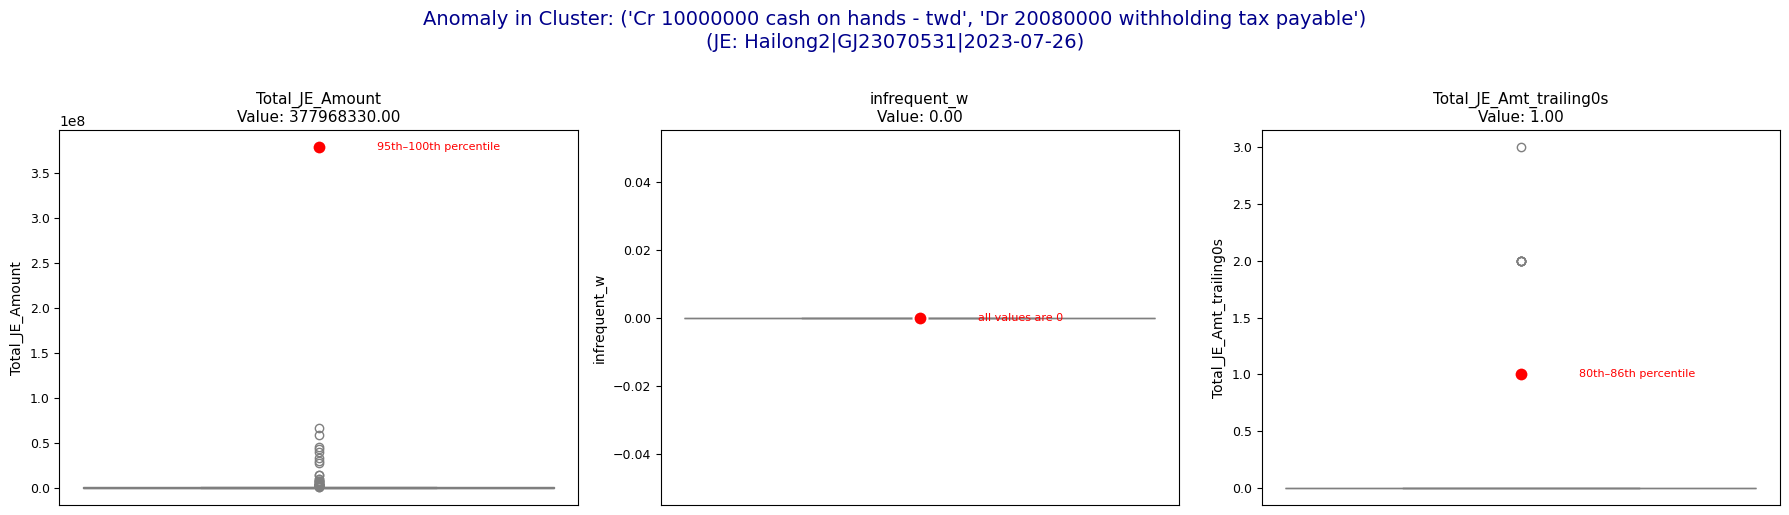

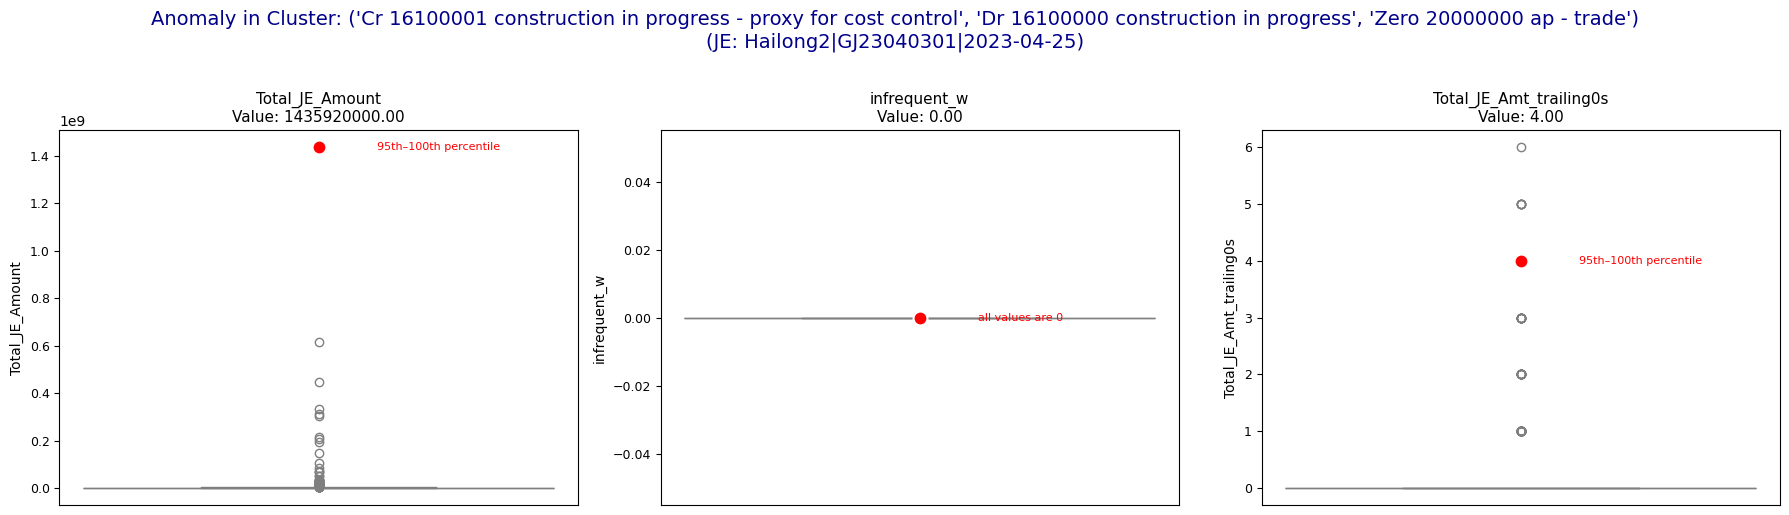

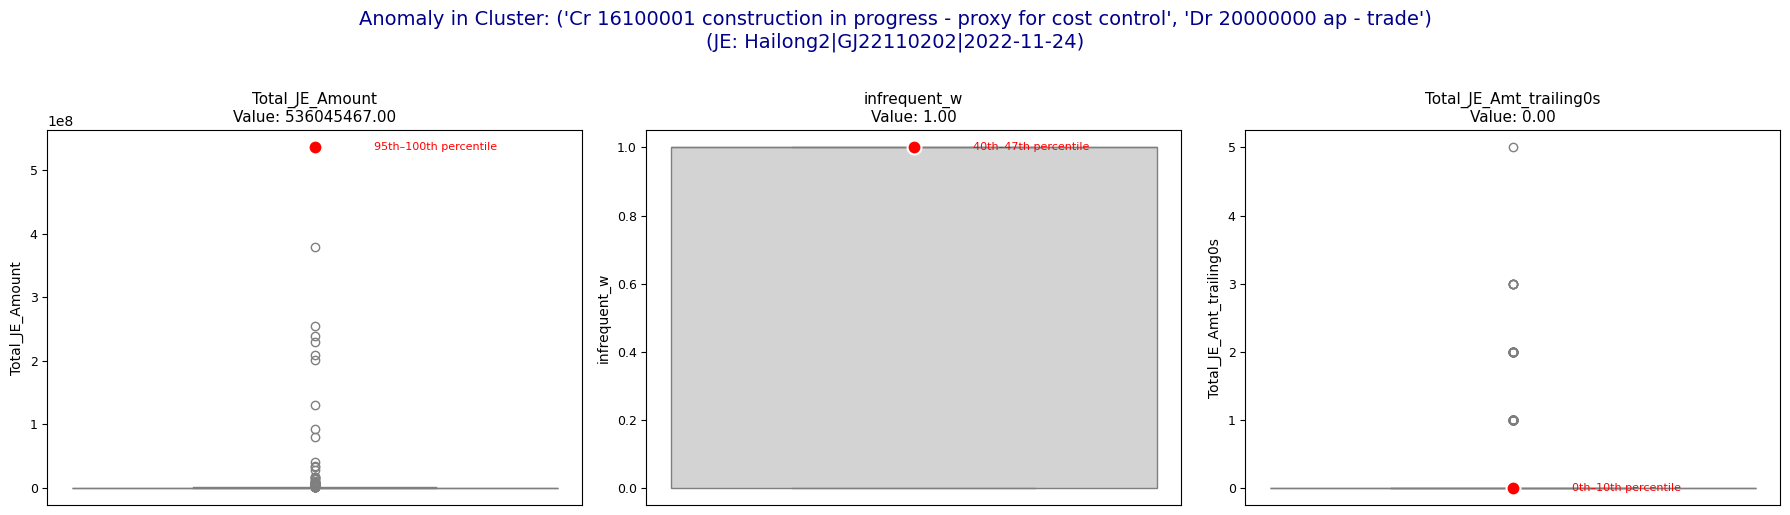

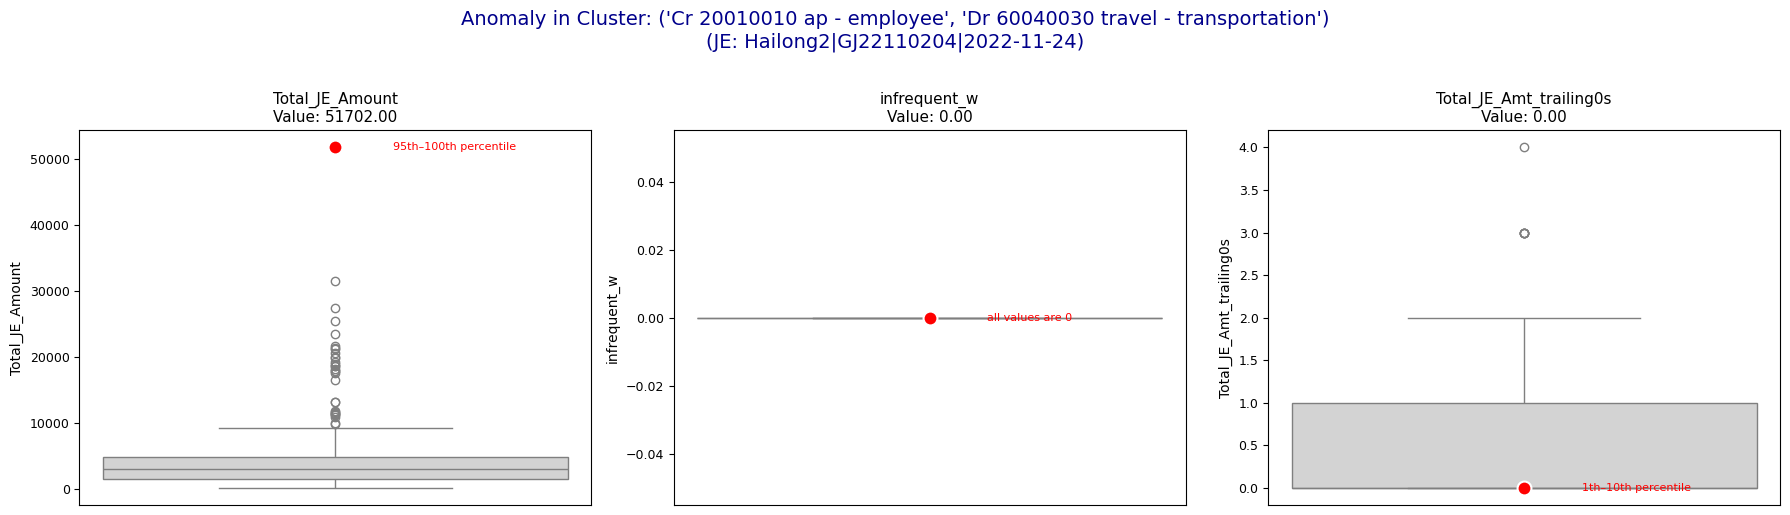

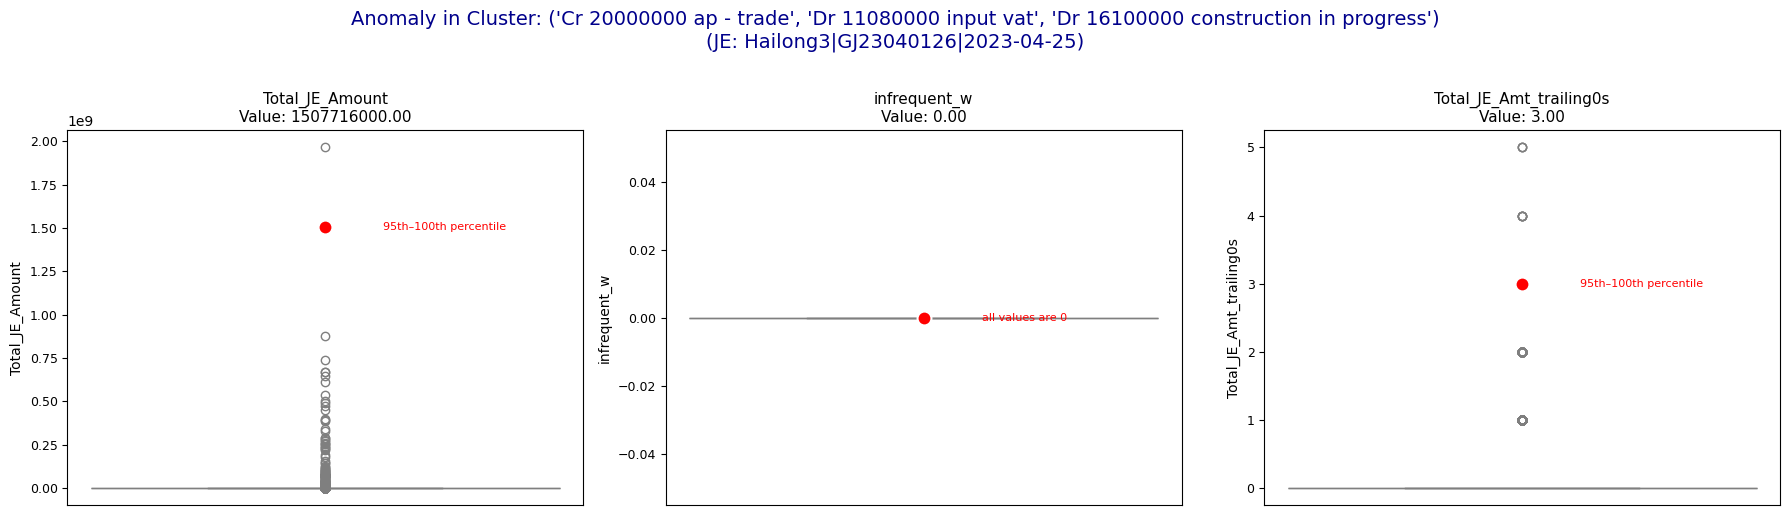

    rank                                    cluster_pattern  \
0      1  (Cr 10000000 cash on hands - twd, Dr 20080000 ...   
1      1  (Cr 10000000 cash on hands - twd, Dr 20080000 ...   
2      1  (Cr 10000000 cash on hands - twd, Dr 20080000 ...   
3      2  (Cr 16100001 construction in progress - proxy ...   
4      2  (Cr 16100001 construction in progress - proxy ...   
5      2  (Cr 16100001 construction in progress - proxy ...   
6      3  (Cr 16100001 construction in progress - proxy ...   
7      3  (Cr 16100001 construction in progress - proxy ...   
8      3  (Cr 16100001 construction in progress - proxy ...   
9      4  (Cr 20010010 ap - employee, Dr 60040030 travel...   
10     4  (Cr 20010010 ap - employee, Dr 60040030 travel...   
11     4  (Cr 20010010 ap - employee, Dr 60040030 travel...   
12     5  (Cr 20000000 ap - trade, Dr 11080000 input vat...   
13     5  (Cr 20000000 ap - trade, Dr 11080000 input vat...   
14     5  (Cr 20000000 ap - trade, Dr 11080000 input va

In [79]:
summary = plot_top_anomalies_boxplots_side_by_side(
    result_df=result,
    features=features,
    cluster_pattern_col='ClusterPattern',
    anomaly_score_col='anomaly_score',
    n_top=5,
    show_percentile_label=True
)

# View results
print(summary)

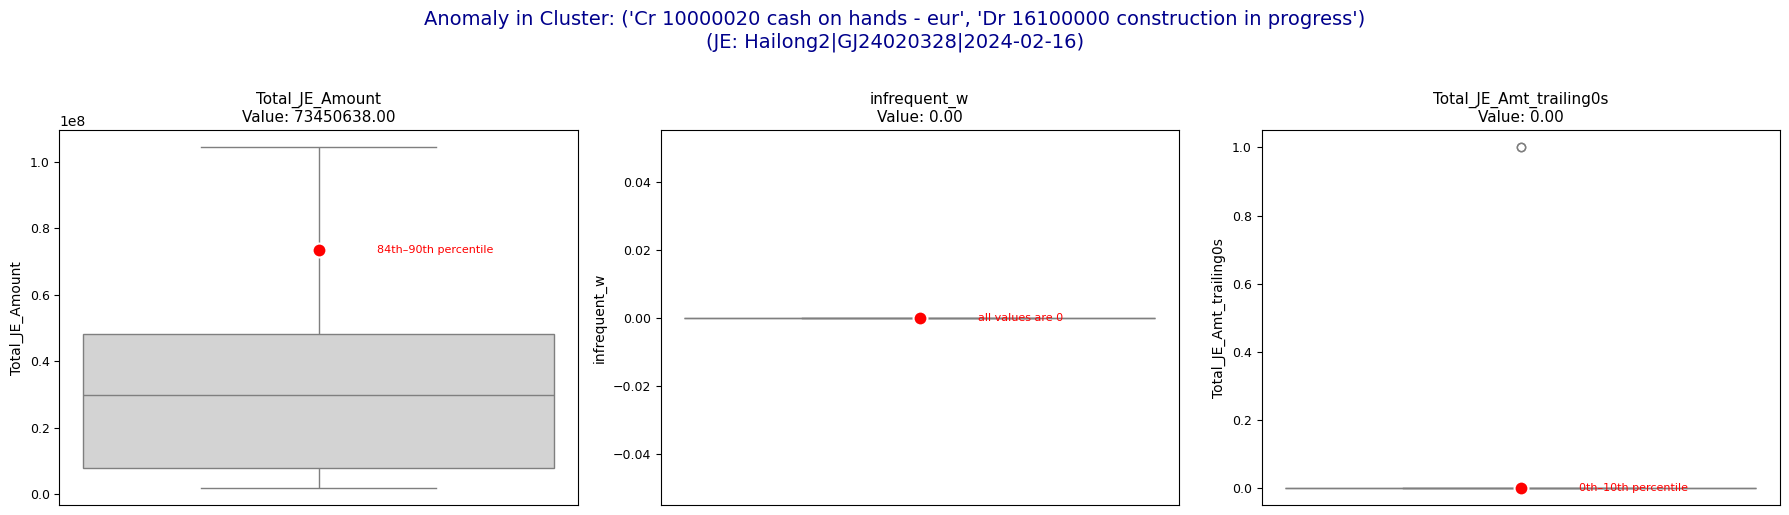

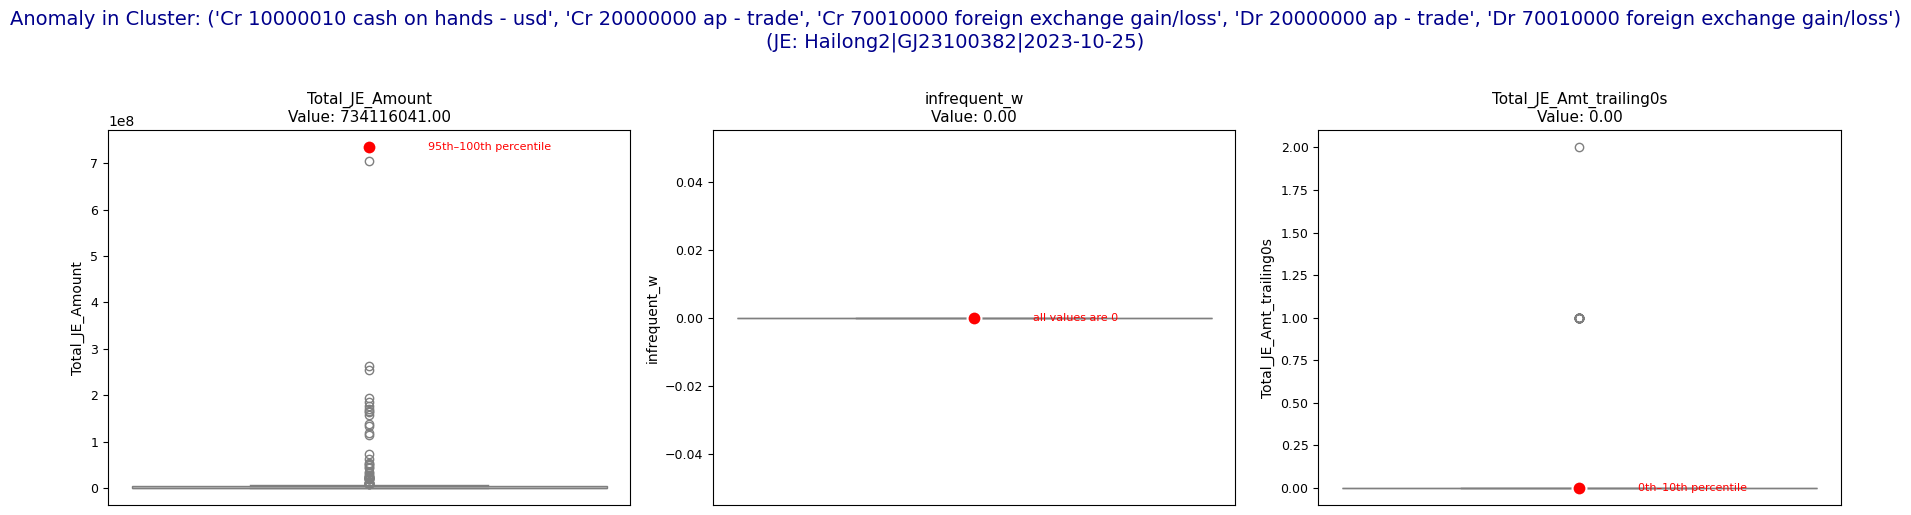

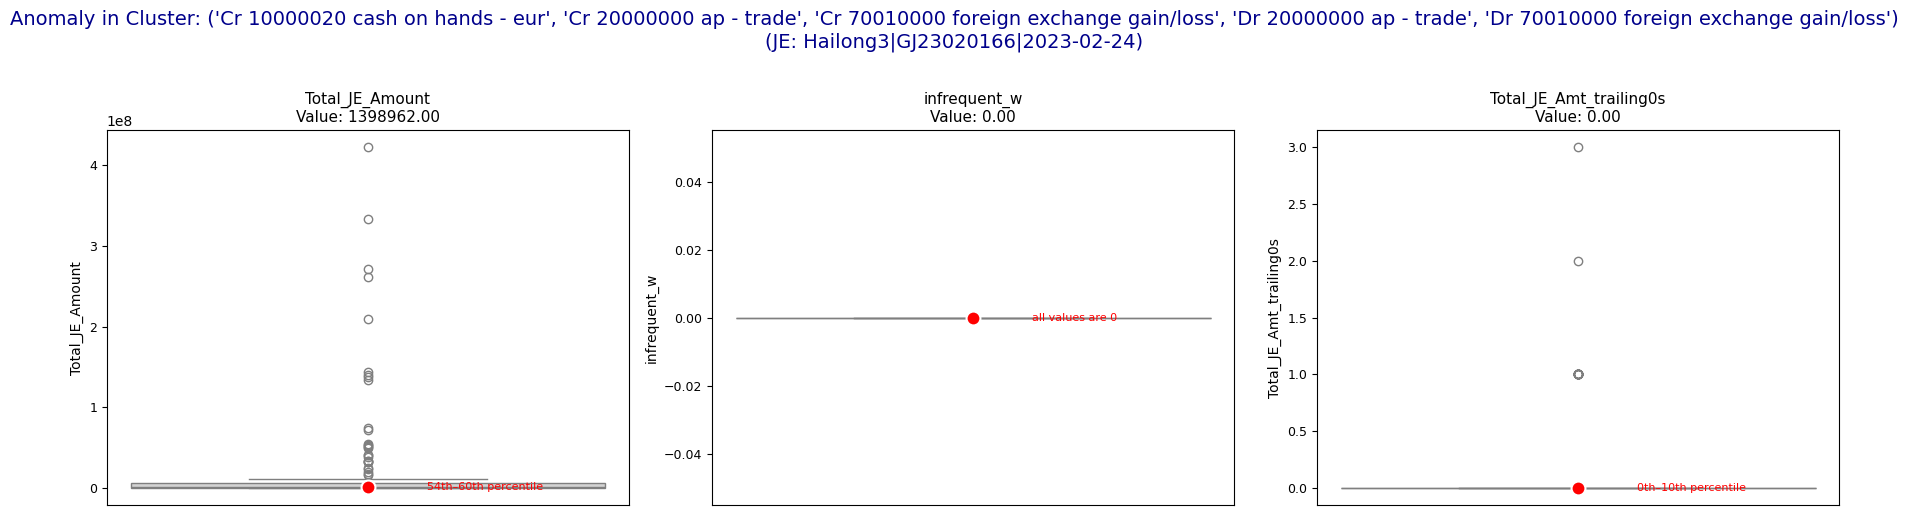

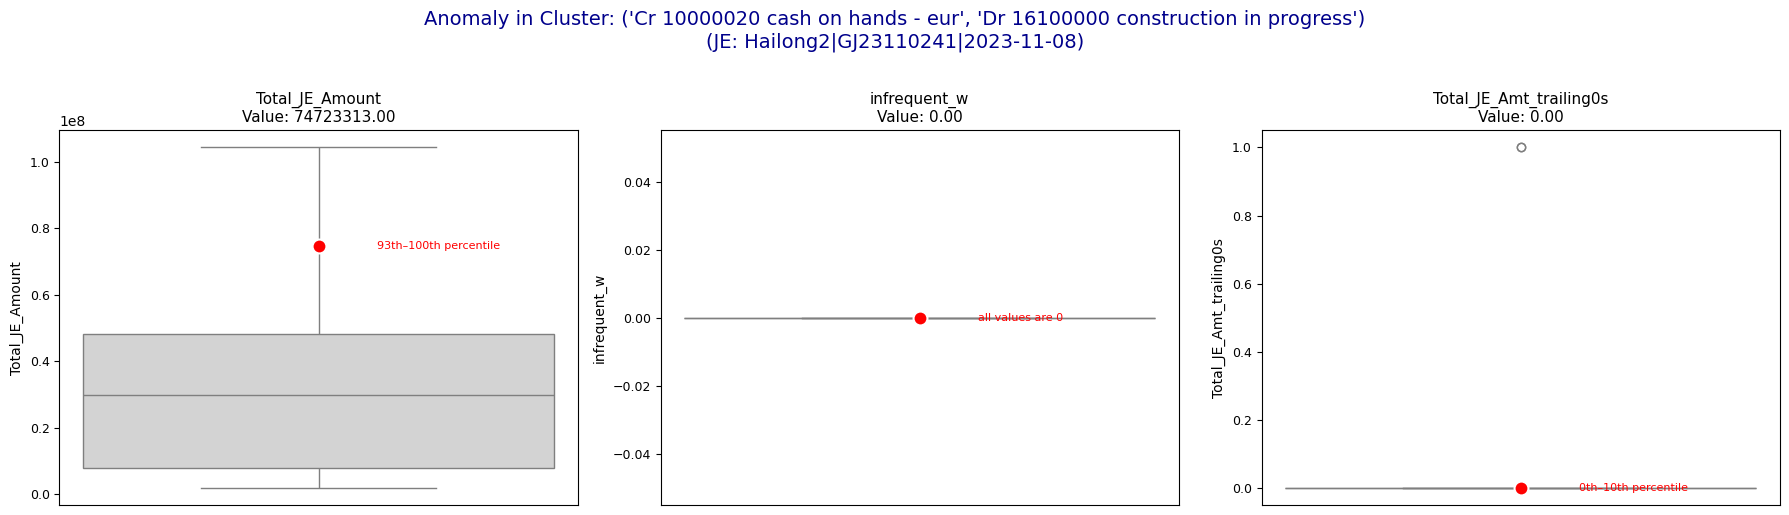

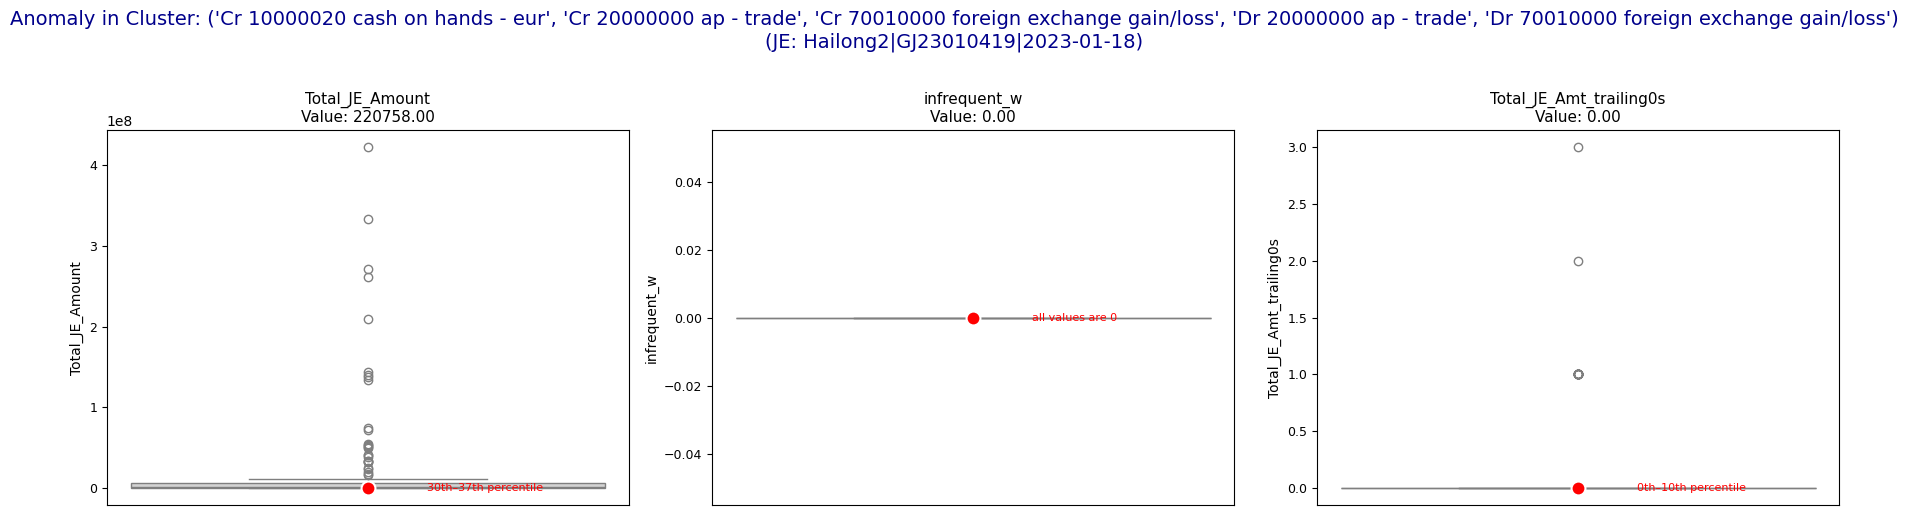

    rank                                    cluster_pattern  \
0      1  (Cr 10000020 cash on hands - eur, Dr 16100000 ...   
1      1  (Cr 10000020 cash on hands - eur, Dr 16100000 ...   
2      1  (Cr 10000020 cash on hands - eur, Dr 16100000 ...   
3      2  (Cr 10000010 cash on hands - usd, Cr 20000000 ...   
4      2  (Cr 10000010 cash on hands - usd, Cr 20000000 ...   
5      2  (Cr 10000010 cash on hands - usd, Cr 20000000 ...   
6      3  (Cr 10000020 cash on hands - eur, Cr 20000000 ...   
7      3  (Cr 10000020 cash on hands - eur, Cr 20000000 ...   
8      3  (Cr 10000020 cash on hands - eur, Cr 20000000 ...   
9      4  (Cr 10000020 cash on hands - eur, Dr 16100000 ...   
10     4  (Cr 10000020 cash on hands - eur, Dr 16100000 ...   
11     4  (Cr 10000020 cash on hands - eur, Dr 16100000 ...   
12     5  (Cr 10000020 cash on hands - eur, Cr 20000000 ...   
13     5  (Cr 10000020 cash on hands - eur, Cr 20000000 ...   
14     5  (Cr 10000020 cash on hands - eur, Cr 20000000

In [80]:
summary = plot_top_anomalies_boxplots_side_by_side(
    result_df=pca_result,
    features=features,
    cluster_pattern_col='ClusterPattern',
    anomaly_score_col='anomaly_score',
    n_top=5,
    show_percentile_label=True
)

# View results
print(summary)